# BT4221 Group 20: Optimising Airfare Booking with Predictive Analytics

Group Members:

Gong Yongjia A0286144X

Jody Tng Jin Zi A0238195W

Wu Shuhan A0266501L

Zhou Jingchu Jeslyn A0275993H

## ✈️ **Overview**

This project aims to **predict the optimal time to book flight tickets** based on a traveler’s destination and departure date, by analyzing historical pricing data.  

📉 The *optimal booking time* is defined as the period when the fare falls **below the 25th percentile** of historical price distributions for similar routes. This helps travelers identify the **lowest possible fare** for their desired routes.

Flight prices fluctuate due to various factors, making it difficult for travelers to determine the best time to book. By leveraging 🧠 **machine learning techniques**, our project provides **data-driven insights** to optimize travel planning.

💼 This can benefit both:
- **Individual travelers** looking for cost savings
- **Businesses** managing corporate travel budgets

---

## 🔍 **Focus Areas**
- 📊 Predicting future flight ticket prices based on historical data  
- 📈 Identifying trends and patterns that indicate the best time to purchase tickets  
- 📆 Analyzing factors such as **seasonality** and **booking windows**

---

## 🚫 **Exclusions**
- ❌ Real-time tracking of ticket prices  
- ❌ External factors like airline-specific promotional deals, last-minute fare changes, or global events and government regulations



# **1. Importing Libraries and Dataset**

In [0]:
# PySpark Session & Core
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import DataFrame
from pyspark.sql import Row
from pyspark.sql.functions import (
    col,
    isnan,
    when,
    percentile_approx,
    mean,
    stddev,
    count,
    avg,
    min,
    max,
    log,
    datediff,
    lit
)
from pyspark.sql.types import (
    NumericType,
    DoubleType,
    DateType,
    StringType,
    IntegerType,
    FloatType
)
from pyspark.sql.window import Window
from pyspark.sql.column import Column
# PySpark MLlib (Features, Pipeline, Models, Evaluators)
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer,
    OneHotEncoder,
    VectorAssembler,
    StandardScaler,
    PCA,
)
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Python Standard Libraries
import math
from datetime import datetime, timedelta
import scipy
from scipy.stats import boxcox
from typing import List, Dict, Tuple, Set, Union, Optional, Any, Callable

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## **1.1. Initialize Spark Session & Load Dataset**

In [0]:
# Initialize Spark Sesison
spark = SparkSession.builder.appName("FlightPrices").getOrCreate()

# Load Dataset
flight_df = spark.read.csv("/FileStore/tables/flight.csv", header=True, inferSchema=True)

# Show a sample (5 rows) of the data
display(flight_df.limit(5))

# Display schema
flight_df.printSchema()

legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
620cd51404373b9bdbbc46a0b657573c,2022-05-29,2022-06-18,LAX,ATL,Y0N,PT4H19M,0,false,false,true,943.26,1028.61,7,1943,1655591400,2022-06-18T15:30:00.000-07:00,1655606940,2022-06-18T22:49:00.000-04:00,ATL,LAX,Delta,DL,Airbus A321,15540,1943,coach
8622d132e890b398c0ad1d62b0232f54,2022-05-03,2022-06-24,CLT,LAX,MA0OA0MQ,PT8H10M,0,false,false,false,479.07,537.1,9,2171,1656073800||1656086520,2022-06-24T08:30:00.000-04:00||2022-06-24T12:02:00.000-04:00,1656078240||1656103200,2022-06-24T09:44:00.000-04:00||2022-06-24T13:40:00.000-07:00,ATL||LAX,CLT||ATL,Delta||Delta,DL||DL,Boeing 717||Airbus A321,4440||16680,228||1943,coach||coach
6f419788769ddb3802d047272ad0a54d,2022-05-02,2022-06-30,LGA,ATL,LAVQA0ML,PT11H54M,1,false,false,false,328.38,382.21,9,1700,1656633540||1656669600,2022-06-30T19:59:00.000-04:00||2022-07-01T06:00:00.000-04:00,1656645360||1656676380,2022-06-30T23:16:00.000-04:00||2022-07-01T07:53:00.000-04:00,MIA||ATL,LGA||MIA,Delta||Delta,DL||DL,Boeing 737-800||Boeing 737-900,11820||6780,1104||596,coach||coach
41f3cd0a63603895e13b5b77630bd84e,2022-06-10,2022-08-04,LAX,SFO,MH7OASMN,PT1H20M,0,false,false,true,189.77,218.6,7,339,1659664800,2022-08-04T19:00:00.000-07:00,1659669600,2022-08-04T20:20:00.000-07:00,SFO,LAX,Alaska Airlines,AS,Embraer 175,4800,339,coach
7f5d8684b672dd3593e30ee946264c31,2022-06-24,2022-07-20,LGA,DFW,LAVQA0BQ,PT6H41M,0,true,false,false,171.16,207.6,9,1487,1658327700||1658343300,2022-07-20T10:35:00.000-04:00||2022-07-20T14:55:00.000-04:00,1658337240||1658351760,2022-07-20T13:14:00.000-04:00||2022-07-20T16:16:00.000-05:00,ATL||DFW,LGA||ATL,Delta||Delta,DL||DL,Airbus A320||Airbus A321,9540||8460,762||725,coach||coach


root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCode: s

## **1.2 EDA on Raw Data**

In [0]:
# Use seaborn whitegrid theme
sns.set_theme(style="whitegrid")

# Consistent color constants
BAR_COLOR = "#4A90E2"         # Blue for bars
TEXT_COLOR = "black"          # Default text
BORDER_COLOR = "#2C3E50"      # Navy for outlines
BOX_FILL_COLOR = BAR_COLOR    # Use same for boxplots
MEDIAN_COLOR = "#FF5733"      # Bright orange-red for median
OUTLIER_COLOR = "#FF5733"     # Same as median for consistency
HIST_EDGE_COLOR = BORDER_COLOR


### **1.2.1 Numeric Data Analysis**

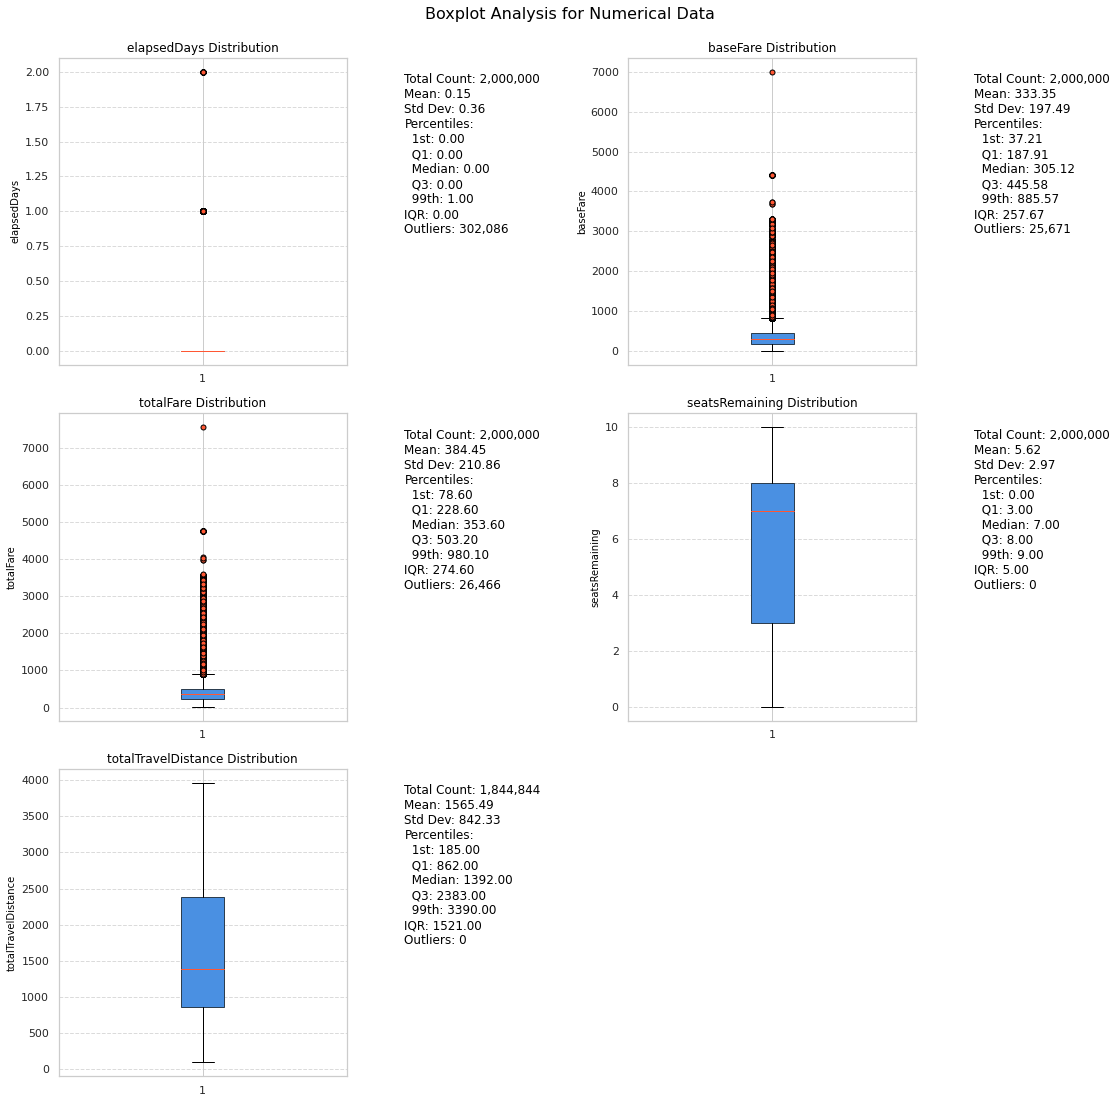

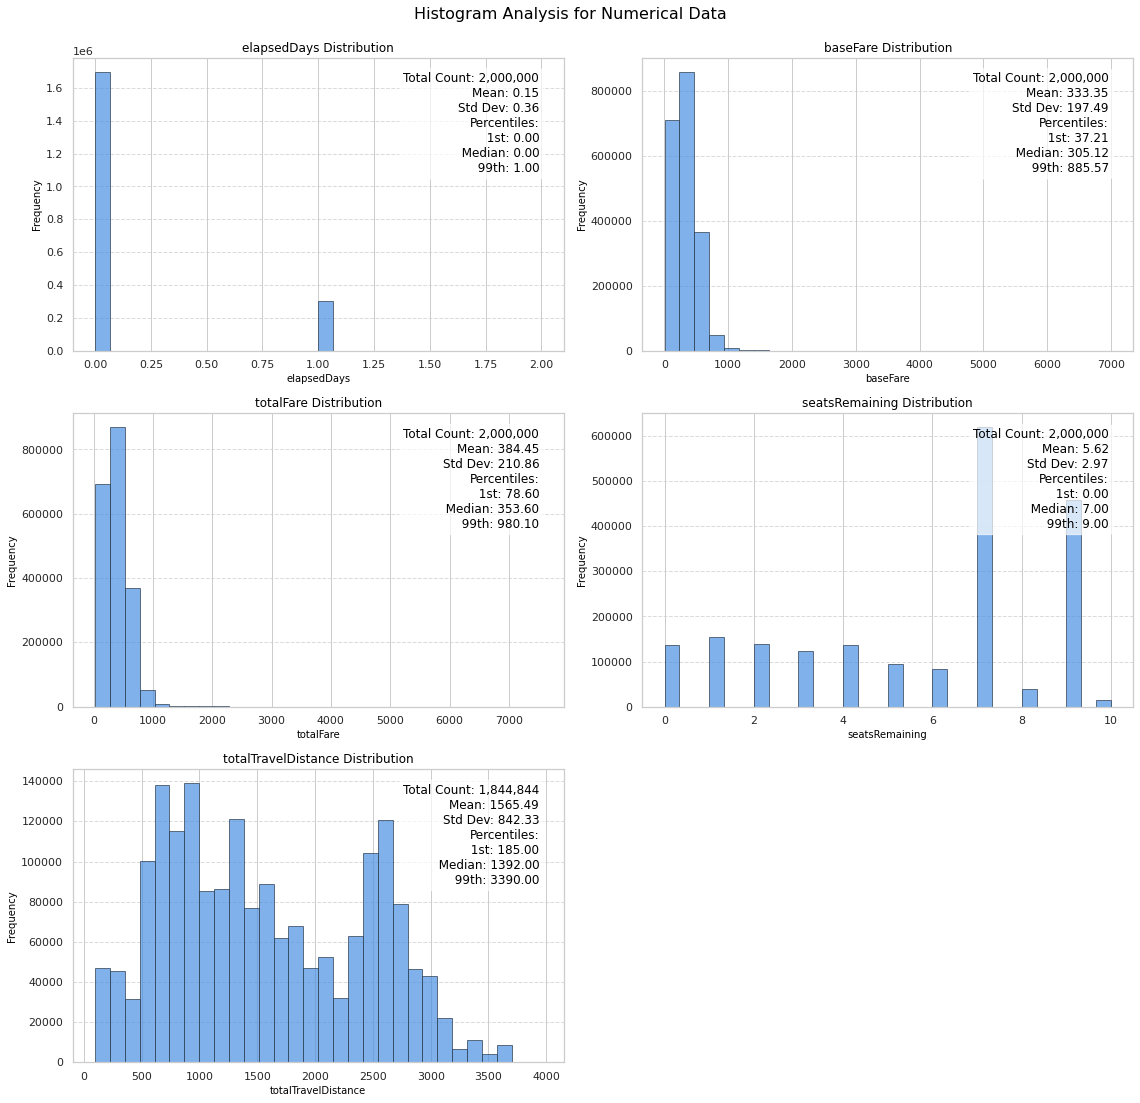

In [0]:
def create_pyspark_boxplots(df: DataFrame, columns: List[str], cols_per_row: int = 2) -> None:
    """
    Generates box plots for the specified numeric columns in a PySpark DataFrame,
    along with detailed statistical annotations.

    Parameters:
    df (DataFrame): The input PySpark DataFrame.
    columns (List[str]): List of column names (numeric) to visualize with box plots.
    cols_per_row (int): Number of plots per row (default is 2).

    Returns:
    None
    """
    num_plots = len(columns)
    num_rows = math.ceil(num_plots / cols_per_row)
    plt.figure(figsize=(cols_per_row * 8, num_rows * 5))

    for i, column in enumerate(columns, 1):
        plt.subplot(num_rows, cols_per_row, i)

        data = (
            df.select(column)
            .rdd.flatMap(lambda x: x)
            .filter(lambda x: x is not None)
            .collect()
        )

        plt.boxplot(
            data,
            patch_artist=True,
            boxprops=dict(facecolor=BOX_FILL_COLOR, color=BORDER_COLOR),
            medianprops=dict(color=MEDIAN_COLOR),
            flierprops=dict(marker="o", markerfacecolor=OUTLIER_COLOR, markersize=5, linestyle="none"),
        )

        stats = df.agg(
            count(column).alias("total_count"),
            mean(column).alias("mean"),
            stddev(column).alias("std"),
            percentile_approx(column, [0.01, 0.25, 0.5, 0.75, 0.99]).alias("percentiles"),
        ).collect()[0]

        q1, median, q3 = stats["percentiles"][1], stats["percentiles"][2], stats["percentiles"][3]
        iqr = q3 - q1

        outliers_count = df.filter(
            (col(column) < q1 - 1.5 * iqr) | (col(column) > q3 + 1.5 * iqr)
        ).count()

        plt.title(f"{column} Distribution", fontsize=12, color=TEXT_COLOR)
        plt.ylabel(column, fontsize=10, color=TEXT_COLOR)
        plt.grid(axis="y", linestyle="--", alpha=0.7)

        plt.text(
            1.2,
            0.95,
            f"Total Count: {stats['total_count']:,}\n"
            f"Mean: {stats['mean']:.2f}\n"
            f"Std Dev: {stats['std']:.2f}\n"
            f"Percentiles:\n"
            f"  1st: {stats['percentiles'][0]:.2f}\n"
            f"  Q1: {q1:.2f}\n"
            f"  Median: {median:.2f}\n"
            f"  Q3: {q3:.2f}\n"
            f"  99th: {stats['percentiles'][4]:.2f}\n"
            f"IQR: {iqr:.2f}\n"
            f"Outliers: {outliers_count:,}",
            transform=plt.gca().transAxes,
            verticalalignment="top",
            horizontalalignment="left",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
            color=TEXT_COLOR
        )

    plt.tight_layout()
    plt.suptitle("Boxplot Analysis for Numerical Data", fontsize=16, color=TEXT_COLOR, y=1.02)
    plt.show()

def create_pyspark_histograms(df: DataFrame, columns: List[str], cols_per_row: int = 2) -> None:
    """
    Generates histograms for the specified numeric columns in a PySpark DataFrame,
    annotated with basic summary statistics.

    Parameters:
    df (DataFrame): The input PySpark DataFrame.
    columns (List[str]): List of column names (numeric) to visualize with histograms.
    cols_per_row (int): Number of plots per row (default is 2).

    Returns:
    None
    """
    num_plots = len(columns)
    num_rows = math.ceil(num_plots / cols_per_row)
    plt.figure(figsize=(cols_per_row * 8, num_rows * 5))

    for i, column in enumerate(columns, 1):
        plt.subplot(num_rows, cols_per_row, i)

        data = (
            df.select(column)
            .rdd.flatMap(lambda x: x)
            .filter(lambda x: x is not None)
            .collect()
        )

        plt.hist(data, bins=30, alpha=0.7, edgecolor=HIST_EDGE_COLOR, color=BAR_COLOR)

        stats = df.agg(
            count(column).alias("total_count"),
            mean(column).alias("mean"),
            stddev(column).alias("std"),
            percentile_approx(column, [0.01, 0.25, 0.5, 0.75, 0.99]).alias("percentiles"),
        ).collect()[0]

        plt.title(f"{column} Distribution", fontsize=12, color=TEXT_COLOR)
        plt.xlabel(column, fontsize=10, color=TEXT_COLOR)
        plt.ylabel("Frequency", fontsize=10, color=TEXT_COLOR)
        plt.grid(axis="y", linestyle="--", alpha=0.7)

        plt.text(
            0.95,
            0.95,
            f'Total Count: {stats["total_count"]:,}\n'
            f'Mean: {stats["mean"]:.2f}\n'
            f'Std Dev: {stats["std"]:.2f}\n'
            f"Percentiles:\n"
            f'  1st: {stats["percentiles"][0]:.2f}\n'
            f'  Median: {stats["percentiles"][2]:.2f}\n'
            f'  99th: {stats["percentiles"][4]:.2f}',
            transform=plt.gca().transAxes,
            verticalalignment="top",
            horizontalalignment="right",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
            color=TEXT_COLOR
        )

    plt.tight_layout()
    plt.suptitle("Histogram Analysis for Numerical Data", fontsize=16, color=TEXT_COLOR, y=1.02)
    plt.show()


def run_pyspark_analysis(df: DataFrame) -> None:
    """
    Runs visual analysis (boxplots and histograms) on all numeric columns in the PySpark DataFrame.

    Parameters:
    df (DataFrame): The input PySpark DataFrame.

    Returns:
    None
    """
    numeric_cols: List[str] = [col for col, dtype in df.dtypes if dtype in ("int", "double")]
    create_pyspark_boxplots(df, numeric_cols)
    create_pyspark_histograms(df, numeric_cols)

# Run the analysis
run_pyspark_analysis(flight_df)


### **Initial Observations**

This initial exploratory analysis of the **raw numerical data** aims to understand the distribution, spread, and outliers of key flight-related features using both boxplots and histograms. These insights help uncover travel behavior patterns, pricing strategies, and operational booking trends — all of which are crucial for developing a robust airfare prediction model.

---

#### **1. elapsedDays: Days Between Booking and Travel**

- **Boxplot Observation**: The median, 25th, and 75th percentiles are all 0, with an interquartile range (IQR) of 0. A high number of outliers (302,086) indicates that although most records represent same-day bookings, a minority of users book 1 or more days in advance.
- **Histogram Observation**: The distribution is heavily right-skewed, with an overwhelming majority of bookings made on the day of travel. A secondary peak at 1 confirms a smaller, but still significant, group who book one day in advance.

**Interpretation**: The data suggests a predominantly last-minute booking pattern, which could be characteristic of either business travelers or high-frequency commuters. This insight might influence promotional strategies or dynamic pricing models aimed at encouraging earlier bookings. 

---

#### **2. baseFare: Base Fare Before Additional Charges**

- **Boxplot Observation**: A median of 305.12 and IQR of 257.67 show moderate variability. However, the presence of over 25,000 outliers and a long upper tail indicates that some routes or classes command very high fares.
- **Histogram Observation**: The distribution is unimodal and highly skewed to the right. Most values cluster below 1000, with very few extreme cases pulling the mean upward (mean = 333.35).

**Interpretation**: While most customers are paying moderate fares, premium travel options or longer-distance routes result in a small subset of high-paying transactions. Pricing strategies could be revisited to manage this skewness or to segment customers based on fare distribution.

---

#### **3. totalFare: Total Amount Paid by Customers**

- **Boxplot Observation**: Similar to baseFare, the totalFare distribution also shows significant skewness. The median is slightly higher at 353.60, and the number of outliers (26,486) reflects variability due to optional add-ons like seat upgrades, baggage, etc.
- **Histogram Observation**: The distribution resembles that of baseFare, reinforcing that most customers pay under 1000 units in total, though the tail shows that some pay significantly more.

**Interpretation**: Additional charges are either modest or consistent with base fare patterns. Marketing teams could use this to understand conversion rates for ancillary services or upselling effectiveness.

---

#### **4. seatsRemaining: Available Seats at Time of Booking**

- **Boxplot Observation**: The variable is well-distributed with a median of 7, and an IQR of 5. There are no outliers, indicating a controlled and uniform seat release or booking behavior.
- **Histogram Observation**: The data shows clear peaks at values like 0 and 10, indicating that flights are often either fully booked or just opened. Intermediate values are less common but still reasonably distributed.

**Interpretation**: Seat availability reflects both booking cycle dynamics and possibly batch seat releases by airlines. Peaks at full capacity or fully open flights might hint at booking surges at specific intervals. Airlines may want to optimize visibility or pricing strategies based on booking windows.

---

#### **5. totalTravelDistance: Total Distance of Journey**

- **Boxplot Observation**: With a median of 1392 and IQR of 1521, this variable shows a wide range, but no outliers were detected. This indicates consistent but diverse travel patterns.
- **Histogram Observation**: A bimodal pattern is observed, with peaks around 500–1000 km and 2300–2500 km. This strongly suggests the existence of distinct travel categories—short-haul and long-haul journeys.

**Interpretation**: Recognizing these distance clusters can help in route-based customer segmentation or classifying ticket types. Airlines or transport providers could tailor their services, promotions, and aircraft types to suit the dominant distance ranges.

---

#### **Overall Summary**

From this exploratory analysis on our raw data, several critical insights emerge for our airfare price prediction model:

- **Heavy right-skewness** in **fare-related features** (baseFare, totalFare) and **booking behavior** (elapsedDays).
- **High concentration at 0 days** for elapsedDays, reflecting mostly last-minute bookings.
- **Consistent seat availability** with edge peaks at 0 and 10, suggesting batch dynamics or high demand during certain periods.
- **Clear distinction in journey lengths** as indicated by the bimodal shape in totalTravelDistance.


### **1.2.2 Categorical Data Analysis**

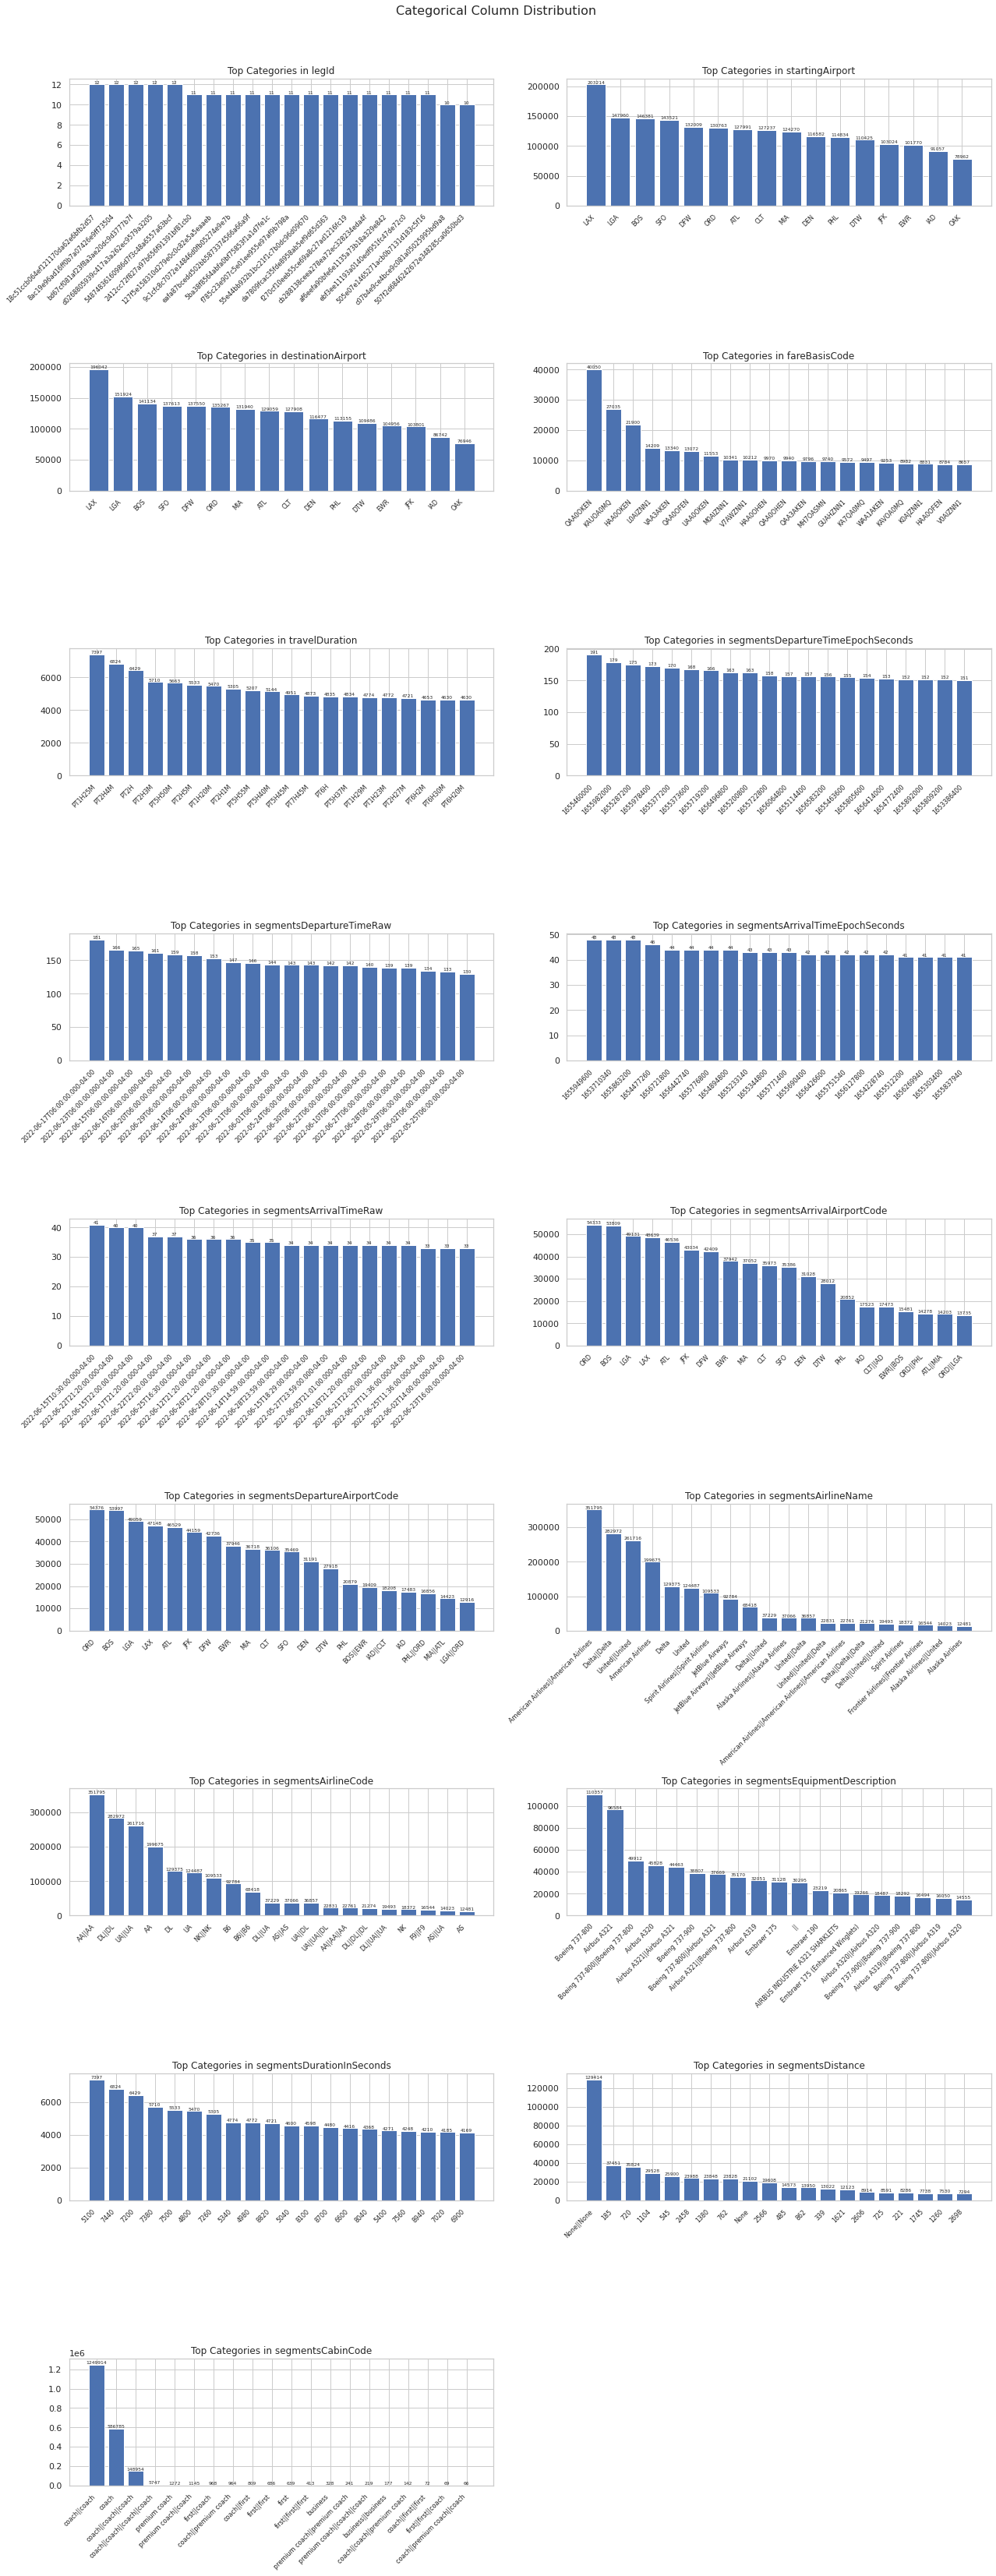

In [0]:
def explore_categorical_columns(df: DataFrame) -> None:
    """
    Visualizes the distribution of categorical (string-type) columns in the given PySpark DataFrame using bar plots.

    For each categorical column, this function:
    - Computes the top 20 most frequent values
    - Displays a bar chart with count labels
    - Handles and skips columns with all missing or empty values

    Parameters:
    df (DataFrame): The input PySpark DataFrame.

    Returns:
    None
    """
    # Identify string-type columns
    categorical_columns = [
        field.name for field in df.schema.fields if isinstance(field.dataType, StringType)
    ]

    if not categorical_columns:
        print("No categorical columns found.")
        return

    # Plot configuration
    num_columns = len(categorical_columns)
    num_rows = math.ceil(num_columns / 2)
    plt.figure(figsize=(18, num_rows * 5))

    for i, column in enumerate(categorical_columns, 1):
        plt.subplot(num_rows, 2, i)

        # Get top 20 most frequent categories
        value_counts = df.groupBy(column).count().orderBy("count", ascending=False)
        top_categories = value_counts.limit(20).toPandas().dropna(subset=[column, "count"])

        if not top_categories.empty:
            bars = plt.bar(top_categories[column], top_categories["count"])
            plt.title(f"Top Categories in {column}")
            plt.xticks(rotation=45, ha="right", fontsize=8)

            # Add count labels to bars
            for bar in bars:
                height = bar.get_height()
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    str(int(height)),
                    ha="center",
                    va="bottom",
                    fontsize=6,
                )
        else:
            # Display placeholder for empty column
            plt.text(
                0.5, 0.5, "No data",
                horizontalalignment="center",
                verticalalignment="center",
                transform=plt.gca().transAxes,
            )

    plt.tight_layout()
    plt.suptitle("Categorical Column Distribution", fontsize=16, y=1.02)
    plt.show()

explore_categorical_columns(flight_df)

### **Observations**

This section provides a breakdown of the most frequent values in **key categorical columns**, highlighting dominant categories, distribution skews, and operational or user behavior patterns.

---

#### **1. Route and Flight Identifiers**

`legId`
- The top 20 `legId` values are distributed fairly evenly (~10-12 occurrences each), suggesting a diverse set of flight legs in the dataset without extreme repetition.

`startingAirport` and `destinationAirport`
- The most common departure and arrival airports include **LAX**, **LAS**, **SFO**, **DEN**, and **PHX**.
- **LAX** dominates both charts, indicating its role as a major hub.
- There's a steep drop in frequency after the top few airports, highlighting route concentration around key cities.

**Interpretation**: These results reflect real-world air traffic dynamics, where large international hubs serve as focal points for domestic and connecting travel.

---

#### **2. Fare and Duration Categories**

`fareBasisCode`
- The code **Q** is the most frequent, followed by variations like **QNR**, **WNR**, **KNRC**, and **HNRC**.
- This implies fare classes like discounted economy dominate the bookings, with relatively fewer premium or specialized fare codes.

`travelDuration`
- Most common durations range from **PT2H0M** to **PT5H0M**, with a gradual drop-off.
- This suggests the dataset is mostly composed of short- to medium-haul flights, consistent with the distance distribution.

---

#### **3. Time-related Segment Features**

`segmentsDepartureTimeEpochSeconds`, `segmentsDepartureTimeRaw`, `segmentsArrivalTimeEpochSeconds`, `segmentsArrivalTimeRaw`
- These features show high cardinality but relatively even distribution among the top 20 values.
- `segmentsDepartureTimeRaw` has peaks between **06:00** and **09:00**, indicating a higher volume of morning flights.
- Similarly, `segmentsArrivalTimeRaw` shows arrivals mostly between **08:00** and **13:00**, aligning with short-to-medium flight durations.

**Interpretation**: Flights are concentrated around typical business and travel hours, suggesting user preference or airline scheduling strategy.

---

#### **4. Segment Airport Codes**

`segmentsDepartureAirportCode` and `segmentsArrivalAirportCode`
- The most common segment-level airports again include **ORD**, **DFW**, **ATL**, **LAX**, and **SFO**, reaffirming their importance as major hubs.

**Interpretation**: These reinforce the earlier airport-level trends and might reflect layover or connection points in multi-leg journeys.

---

#### **5. Airline and Equipment Information**

`segmentsAirlineName` and `segmentsAirlineCode`
- Dominant airlines include **American Airlines**, **United Airlines**, and **Delta Air Lines**.
- Corresponding airline codes (**AA**, **UA**, **DL**) are most common, confirming their major market share.

`segmentsEquipmentDescription`
- Boeing aircraft such as **737-800**, **757-200**, and **737-700** are the most frequently used, suggesting standardization in fleet for domestic routes.

**Interpretation**: These details could be useful for demand forecasting, operational planning, and understanding airline dominance in the dataset.

---

#### **6. Flight Segment Distance and Duration**

`segmentsDistance`
- A notable spike in **nonstop** flights and short distances (under 300 miles) shows that direct and short flights dominate.
- This further supports the earlier insight that the dataset contains mostly short-haul or regional flights.

`segmentsDurationInSeconds`
- Common duration brackets include **5100–7200 seconds (1.5 to 2 hours)**.
- This aligns well with earlier `travelDuration` observations, confirming internal consistency.

---

#### **7. Cabin Class Information**

`segmentsCabinCode`
- The most common codes include **coach**, **coach/coach**, and **premium coach**.
- Very few instances of business or first class suggest that the dataset is primarily composed of economy travelers.

**Interpretation**: Pricing and product strategies could be targeted accordingly, especially toward optimizing revenue from economy-class customers.

---

#### **Overall Summary**

The categorical data shows strong dominance in:
- **Airports**: LAX, SFO, ORD, and ATL are key hubs.
- **Airlines**: American, United, and Delta dominate.
- **Aircraft**: Boeing aircraft, especially 737 variants, are prevalent.
- **Cabin Class**: Coach and economy classes make up the majority.
- **Flight Patterns**: Nonstop, short-haul, and morning departures are most common.


### **1.2.3 Further Analysis**

In [0]:
display(
    flight_df.filter(F.col("totalTravelDistance").isNull())
             .select("legid", "totalTravelDistance", "segmentsDistance")
             .limit(5)
)

legid,totalTravelDistance,segmentsDistance
2d27f28ea39de6e1cc0b0f17d8f8fa8b,null,None||None
8f831229e4db64d5868f04845d6ddc89,null,None||None
9661f8606b490c94e3590486ed558cbf,null,None||None
fde2c64a4b9875e0bdb316cb8606c213,null,None
b9276bd7af0f52933bd9c48785a63ae3,null,None||None


#### **Observation**

We noticed that whenever `totalTravelDistance` is not available, the corresponding `segmentsDistance` is also unavailable. This observation suggests that missing values in `totalTravelDistance` are directly tied to missing values in `segmentsDistance`. Therefore, any imputation or handling of missing data should consider this relationship to maintain data consistency.

## **2.1 Data Cleaning**

### **2.1.1 Drop NULL Values**

### **Rationale**

As explained in **Section 1.2.3**, missing values in `totalTravelDistance` are directly tied to missing values in `segmentsDistance`. Therefore, any imputation or handling of missing data should consider this relationship to maintain data consistency.

To ensure the integrity of the dataset, we drop rows with null values in `totalTravelDistance`.

It has been observed that there are still missing values in the `segmentsEquipmentDescription` column.

Since `segmentsEquipmentDescription` primarily provides descriptive information about the aircraft used, it is not directly relevant to our predictive modeling or analysis objectives.

Retaining rows with null values in this column would unnecessarily complicate the dataset without adding significant value to the analysis. Therefore, we opted to drop rows with missing values in this column to streamline the dataset and maintain focus on more impactful features.

In [0]:
def show_missing_values(df: DataFrame) -> None:
    """
    Displays the count and percentage of missing values for each column in the given PySpark DataFrame.
    
    Handles numeric and string types with appropriate logic for identifying missing or empty values.

    Parameters:
    df (DataFrame): The input PySpark DataFrame.

    Returns:
    None
    """
    missing_exprs = []

    for field in df.schema.fields:
        col_name = field.name
        if isinstance(field.dataType, NumericType):
            expr = F.sum((col(col_name).isNull() | isnan(col(col_name))).cast("int")).alias(col_name)
        elif isinstance(field.dataType, StringType):
            expr = F.sum((col(col_name).isNull() | (col(col_name) == "")).cast("int")).alias(col_name)
        else:
            expr = F.sum(col(col_name).isNull().cast("int")).alias(col_name)
        missing_exprs.append(expr)

    # Calculate missing value counts
    missing_counts = df.select(*missing_exprs)
    display(missing_counts)

    # Calculate percentage of missing values
    total_rows = df.count()
    missing_percentages = missing_counts.select(
        *[(col(c) / total_rows * 100).alias(c) for c in missing_counts.columns]
    )

    print("\nPercentage of missing values:")
    display(missing_percentages)

    print("\nMissing values in the dataset:")
    display(missing_counts)

print("Before dropping null rows:")
show_missing_values(flight_df)

Before dropping null rows:


legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,0,0,0,0,0,0,0,0,0,0,0,0,0,155156,0,0,0,0,0,0,0,0,39914,0,0,0



Percentage of missing values:


legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.7578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.9956999999999998,0.0,0.0,0.0



Missing values in the dataset:


legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,0,0,0,0,0,0,0,0,0,0,0,0,0,155156,0,0,0,0,0,0,0,0,39914,0,0,0


In [0]:
# Drop rows with null values in totalTravelDistance and segmentsEquipmentDescription
flight_df = flight_df.dropna(subset=["totalTravelDistance", "segmentsEquipmentDescription"])

In [0]:
print("After dropping null rows:")
show_missing_values(flight_df)

After dropping null rows:


legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



Percentage of missing values:


legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Missing values in the dataset:


legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **2.1.2 Dropping Outliers**

In [0]:
def remove_outliers_with_display(
    df: DataFrame,
    columns: List[str] = ["totalFare", "baseFare"]
) -> Tuple[DataFrame, DataFrame, Dict[str, Dict[str, float]]]:
    """
    Identifies and removes outliers from the specified numeric columns in a PySpark DataFrame
    using the IQR (Interquartile Range) method. Also displays a summary of removed rows.

    Parameters:
    df (DataFrame): The input PySpark DataFrame.
    columns (List[str]): A list of numeric columns to check for outliers.

    Returns:
    Tuple[DataFrame, DataFrame, Dict[str, Dict[str, float]]]:
        - filtered_df: The DataFrame after removing outliers.
        - removed_rows_df: DataFrame containing rows that were removed as outliers.
        - outlier_stats: Dictionary of outlier boundaries and row counts for each column.
    """
    spark = df.sparkSession
    df.createOrReplaceTempView("original_data")
    outlier_stats: Dict[str, Dict[str, float]] = {}
    removed_rows_list: List[DataFrame] = []

    for column in columns:
        # Compute IQR bounds using Spark SQL
        percentiles = spark.sql(
            f"SELECT percentile_approx({column}, array(0.25, 0.75)) as percentiles FROM original_data"
        ).collect()[0]["percentiles"]

        q1, q3 = percentiles
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Collect outlier rows for the column
        removed_query = f"""
            SELECT * FROM original_data
            WHERE {column} < {lower_bound} OR {column} > {upper_bound}
        """
        removed_rows = spark.sql(removed_query)
        removed_rows_list.append(removed_rows)

        # Store stats for summary display
        original_count = df.count()
        removed_count = removed_rows.count()
        outlier_stats[column] = {
            "original_count": original_count,
            "removed_count": removed_count,
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
            "q1": q1,
            "q3": q3,
            "iqr": iqr,
        }

    # Combine removed rows across all columns
    if removed_rows_list:
        removed_rows_df = removed_rows_list[0]
        for additional_removed in removed_rows_list[1:]:
            removed_rows_df = removed_rows_df.union(additional_removed)
    else:
        removed_rows_df = spark.createDataFrame([], df.schema)

    # Filter out outliers based on combined IQR conditions
    filter_conditions = " AND ".join(
        f"{col} >= {stats['lower_bound']} AND {col} <= {stats['upper_bound']}"
        for col, stats in outlier_stats.items()
    )
    filtered_df = spark.sql(f"""
        SELECT * FROM original_data
        WHERE {filter_conditions}
    """)

    # Create and display summary table
    summary_data = [
        Row(
            column=col_name,
            original_rows=stats["original_count"],
            removed_rows=stats["removed_count"],
            lower_bound=round(stats["lower_bound"], 2),
            upper_bound=round(stats["upper_bound"], 2),
            q1=round(stats["q1"], 2),
            q3=round(stats["q3"], 2),
            iqr=round(stats["iqr"], 2),
        )
        for col_name, stats in outlier_stats.items()
    ]
    summary_df = spark.createDataFrame(summary_data)
    display(summary_df)

    return filtered_df, removed_rows_df, outlier_stats

filtered_df, removed_df, stats = remove_outliers_with_display(flight_df)
display(removed_df.limit(5))
flight_df = filtered_df

column,original_rows,removed_rows,lower_bound,upper_bound,q1,q3,iqr
totalFare,1811452,23791,-176.9,931.1,238.6,515.6,277.0
baseFare,1811452,24433,-178.14,837.66,202.79,456.74,253.95


legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
620cd51404373b9bdbbc46a0b657573c,2022-05-29,2022-06-18,LAX,ATL,Y0N,PT4H19M,0,false,false,true,943.26,1028.61,7,1943,1655591400,2022-06-18T15:30:00.000-07:00,1655606940,2022-06-18T22:49:00.000-04:00,ATL,LAX,Delta,DL,Airbus A321,15540,1943,coach
29aabb2e25d77f04e162907f57543d87,2022-05-18,2022-05-31,OAK,BOS,BH0OASMN,PT8H32M,0,false,false,false,962.79,1058.6,3,3161,1654025100||1654036500,2022-05-31T12:25:00.000-07:00||2022-05-31T15:35:00.000-07:00,1654032300||1654055820,2022-05-31T14:25:00.000-07:00||2022-05-31T23:57:00.000-04:00,SEA||BOS,OAK||SEA,Alaska Airlines||Alaska Airlines,AS||AS,Embraer 175||Boeing 737 MAX 9,7200||19320,672||2489,coach||coach
be008baf4e4f09598d26e3fedb9e9de2,2022-05-01,2022-05-30,BOS,OAK,KAUOA0MQ,PT17H10M,0,false,false,false,864.19,962.7,5,2743,1653918000||1653949200||1653972660,2022-05-30T09:40:00.000-04:00||2022-05-30T18:20:00.000-04:00||2022-05-30T22:51:00.000-06:00,1653922920||1653969600||1653979800,2022-05-30T11:02:00.000-04:00||2022-05-30T22:00:00.000-06:00||2022-05-30T23:50:00.000-07:00,JFK||SLC||OAK,BOS||JFK||SLC,Delta||Delta||Delta,DL||DL||DL,Embraer 175||Airbus A321||Embraer 175 (Enhanced Winglets),4920||20400||7140,185||1970||588,coach||coach||coach
3b6bbea877de4b84510d08aebd5c0ad0,2022-05-08,2022-05-16,LAX,DTW,H0APZNN1,PT6H44M,0,false,false,false,853.95,941.6,2,2210,1652724000||1652738820,2022-05-16T11:00:00.000-07:00||2022-05-16T17:07:00.000-05:00,1652734500||1652748240,2022-05-16T15:55:00.000-05:00||2022-05-16T20:44:00.000-04:00,DFW||DTW,ONT||DFW,American Airlines||American Airlines,AA||AA,Boeing 737-800||Boeing 737-800,10500||9420,1215||995,coach||coach
09cffa7dca2a1e6e05a75483e0e39246,2022-06-02,2022-07-10,OAK,DTW,KATOA0MC,PT9H35M,0,false,false,false,899.53,995.1,5,2110,1657472700||1657485300||1657495800,2022-07-10T10:05:00.000-07:00||2022-07-10T14:35:00.000-06:00||2022-07-10T17:30:00.000-06:00,1657479360||1657490700||1657507200,2022-07-10T12:56:00.000-06:00||2022-07-10T16:05:00.000-06:00||2022-07-10T22:40:00.000-04:00,SLC||DEN||DTW,OAK||SLC||DEN,Delta||United||United,DL||UA||UA,Embraer 175 (Enhanced Winglets)||Airbus A320||Embraer 175 (Enhanced Winglets),6660||5400||11400,588||380||1142,coach||coach||coach


## **2.2. Data Preprocessing**

1. **Travel Duration (in hours)**:
    - The `travelDuration` column, originally in the format `PTxHxM`, is converted into total hours (e.g., `PT2H30M` becomes `2.5` hours). This transformation simplifies analysis and modeling by standardizing the duration into a numeric format.

2. **Elapsed Days**:
    - The `elapsedDays` column represents the number of days between the booking date (`searchDate`) and the travel date (`flightDate`). This feature is crucial for understanding booking behavior and its impact on pricing.

3. **flightDate**:
    - The `flightDate` column is used for time-based split for model training.

4. **Binary Indicators for Boolean Columns**:
    - Columns such as `isBasicEconomy` and `isRefundable` are converted into binary indicators (`1` for `true`, `0` for `false`). This ensures compatibility with machine learning models that require numeric inputs.

5. **Festival Indicator**:
    - A new column, `isFestival`, is added to indicate whether the flight date falls within ±1 day of a holiday. This feature captures the impact of holidays on travel demand and pricing.

6. **Days Until Departure**:
    - The `daysUntilDeparture` column calculates the difference in days between the `flightDate` and `searchDate`. This feature helps analyze how ticket prices vary as the departure date approaches.

7. **Day of the Week**:
    - A new column, `dayOfTheWeek`, extracts the day of the week (e.g., Monday, Tuesday) from the `flightDate`. This feature is useful for identifying patterns in travel behavior and pricing based on the day of the week.

8. **Number of Segments**:
    - The `numOfSegments` column counts the number of flight segments in a journey. This is derived from the `segmentsDistance` column by splitting the values on `||` and counting the segments.

9. **Layover Duration**:
    - The `layoverDuration` column calculates the total layover time (in hours) between flight segments. This feature provides insights into the overall travel experience and its impact on pricing.
    - Layover duration is a critical feature for understanding the overall travel experience. Long layovers can significantly impact passenger satisfaction and travel time.
    - By calculating the total layover duration, we can better analyze and optimize flight schedules, pricing, and passenger preferences.


10. **Airline Presence Indicators**:
    - Binary indicators are created for the presence of specific airlines in the journey (e.g., `isUA`, `isAA`, `isDL`). These features help capture the influence of airline-specific factors on pricing.

11. **Cabin Class Indicators**:
     - Binary indicators are added for the presence of business or first-class cabins in the journey. These features help differentiate between economy and premium travel experiences.

12. **Total Travel Distance**:
     - The `totalTravelDistance` column is retained to represent the total distance of the journey. This feature is critical for understanding the relationship between distance and pricing.

These data preprocessing steps help enhance the dataset by providing more granular insights into travel behavior, pricing patterns, and operational factors. They are designed to improve the performance of machine learning models and support more detailed exploratory data analysis.

In [0]:
def convert_duration_to_hours(duration_col: Column) -> Column:
    """
    Converts a PySpark duration string column (in ISO 8601 format like 'PT2H30M') into total hours,
    rounded to the nearest 0.5 (e.g., 2.5, 3.0).

    Parameters:
    duration_col (Column): A PySpark Column containing duration strings in the format 'PT#H#M'.

    Returns:
    Column: A new PySpark Column representing the total duration in hours, rounded to the nearest 0.5.
    """
    # Extract hours and minutes using regex (e.g., 'PT2H30M' → 2 and 30)
    hours = F.regexp_extract(duration_col, r"PT(\d+)H", 1).cast("double")
    minutes = F.regexp_extract(duration_col, r"H(\d+)M", 1).cast("double")

    # Calculate total hours (e.g., 2 + 30/60 = 2.5) and round to nearest 0.5
    total_hours = hours + (minutes / 60)
    rounded_hours = F.round(total_hours * 2) / 2

    return rounded_hours

In [0]:
def calculate_layover_duration() -> Column:
    """
    Calculates total layover duration (in hours) for multi-segment flights using epoch timestamps.

    Returns:
    Column: A PySpark column representing the total layover time in hours,
            rounded to the nearest 0.5. Returns 0.0 for direct (non-stop) flights.

    Logic:
    - If the flight has only one segment → layover = 0.0
    - Otherwise:
        1. Split both `segmentsDepartureTimeEpochSeconds` and `segmentsArrivalTimeEpochSeconds` into arrays.
        2. Pair each arrival (except the last) with the next departure (starting from the second).
        3. Subtract arrival from next departure → gives layover in seconds.
        4. Aggregate the time differences, convert to hours.
        5. Round to the nearest 0.5 hour.
    """
    return F.when(
        F.size(F.split("segmentsDepartureTimeEpochSeconds", "\\|\\|")) <= 1,
        0.0
    ).otherwise(
        F.round(
            F.expr(
                """
                (
                    aggregate(
                        zip_with(
                            slice(split(segmentsDepartureTimeEpochSeconds, '\\\\|\\\\|'), 2, size(split(segmentsDepartureTimeEpochSeconds, '\\\\|\\\\|'))),
                            slice(split(segmentsArrivalTimeEpochSeconds, '\\\\|\\\\|'), 1, size(split(segmentsArrivalTimeEpochSeconds, '\\\\|\\\\|')) - 1),
                            (x, y) -> cast(x as double) - cast(y as double)
                        ),
                        0D,
                        (acc, x) -> acc + x
                    ) / 3600
                ) * 2
                """
            )
        ) / 2
    )

In [0]:
def get_us_holiday_dates() -> Tuple[DataFrame, List[str]]:
    """
    Generates a list of US holiday dates and their surrounding ±1 day windows,
    based on observed public holidays. Also returns the holiday DataFrame for reference.

    Returns:
    Tuple[DataFrame, List[str]]:
        - holiday_df: A Spark DataFrame containing holiday names and dates.
        - holiday_dates_list: A list of strings (yyyy-mm-dd) representing holiday, day before, and day after.
    """
    # Manually defined subset of US holidays (observed format)
    holiday_data: List[Tuple[str, str]] = [
        ("Good Friday", "2022-04-15"),
        ("Labor Day (International)", "2022-05-01"),
        ("Memorial Day", "2022-05-30"),
        ("Juneteenth (observed)", "2022-06-20"),
        ("Independence Day", "2022-07-04"),
    ]

    # Create holiday DataFrame
    holiday_df = spark.createDataFrame(holiday_data, ["holiday_name", "date"])
    holiday_df = holiday_df.withColumn("date", F.to_date(F.col("date")))

    # Extract ±1 day windows for each holiday
    holiday_dates: Set[str] = set()
    for _, date_str in holiday_data:
        holiday_date = datetime.strptime(date_str, "%Y-%m-%d")
        for offset in [-1, 0, 1]:
            new_date = holiday_date + timedelta(days=offset)
            holiday_dates.add(new_date.strftime("%Y-%m-%d"))

    holiday_dates_list = sorted(list(holiday_dates))
    return holiday_df, holiday_dates_list

In [0]:
# -----------------------------
# Data Cleaning & Feature Engineering
# -----------------------------
# Clean and transform flight data for modeling
# Includes: casting, derived features, airline flags, time-based logic, and segment metrics

# Extract holidays
holiday_df, holiday_dates_list = get_us_holiday_dates()

cleaned_flight_df: DataFrame = flight_df.select(
    # Identifiers and key info
    "legid",  # Unique flight identifier
    "totalFare",
    "flightDate",

    # Categorical string features (explicitly casted)
    F.col("startingAirport").cast("string"),
    F.col("destinationAirport").cast("string"),

    # Duration: Convert ISO string like 'PT2H30M' into hours, rounded to nearest 0.5
    convert_duration_to_hours(F.col("travelDuration")).alias("travelDuration"),

    # Booking behavior
    F.col("elapsedDays").cast("int").alias("elapsedDays"),
    F.datediff(F.col("flightDate"), F.col("searchDate")).cast("int").alias("daysUntilDeparture"),

    # Boolean conversions: from string → int
    F.when(F.col("isBasicEconomy") == "true", 1).otherwise(0).cast("int").alias("isBasicEconomy"),
    F.when(F.col("isRefundable") == "true", 1).otherwise(0).cast("int").alias("isRefundable"),

    # Seats left at time of search
    F.col("seatsRemaining").cast("int").alias("seatsRemaining"),

    # Holiday-related feature
    F.when(
        F.date_format("flightDate", "yyyy-MM-dd").isin(holiday_dates_list), 1
    ).otherwise(0).cast("int").alias("isFestival"),

    # Distance
    "totalTravelDistance",

    # Time-based features
    F.date_format(F.col("flightDate"), "E").alias("dayOfTheWeek"),

    # Segment info: count segments by splitting on '||'
    F.when(
        F.col("segmentsDistance").contains("||"),
        F.size(F.split("segmentsDistance", "\\|\\|")) + 1
    ).otherwise(1).cast("int").alias("numOfSegments"),

    # Layover calculation (computed via function)
    calculate_layover_duration().alias("layoverDuration"),

    # Airline binary indicators
    *[
        F.when(F.col("segmentsAirlineCode").contains(code), 1)
        .otherwise(0).cast("int").alias(f"is{code}")
        for code in ["UA", "AA", "4B", "LF", "B6", "DL", "9K", "F9", "9X", "AS", "KG", "SY"]
    ],

    # Cabin class flags
    F.array_contains(F.split(F.col("segmentsCabinCode"), "\\|"), "business").cast("int").alias("hasBusinessClass"),
    F.array_contains(F.split(F.col("segmentsCabinCode"), "\\|"), "first").cast("int").alias("hasFirstClass"),
)

# Display first few rows
display(cleaned_flight_df.limit(5))

legid,totalFare,flightDate,startingAirport,destinationAirport,travelDuration,elapsedDays,daysUntilDeparture,isBasicEconomy,isRefundable,seatsRemaining,isFestival,totalTravelDistance,dayOfTheWeek,numOfSegments,layoverDuration,isUA,isAA,is4B,isLF,isB6,isDL,is9K,isF9,is9X,isAS,isKG,isSY,hasBusinessClass,hasFirstClass
8622d132e890b398c0ad1d62b0232f54,537.1,2022-06-24,CLT,LAX,8.0,0,52,0,0,9,0,2171,Fri,3,2.5,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6f419788769ddb3802d047272ad0a54d,382.21,2022-06-30,LGA,ATL,12.0,1,59,0,0,9,0,1700,Thu,3,6.5,0,0,0,0,0,1,0,0,0,0,0,0,0,0
41f3cd0a63603895e13b5b77630bd84e,218.6,2022-08-04,LAX,SFO,1.5,0,55,0,0,7,0,339,Thu,1,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7f5d8684b672dd3593e30ee946264c31,207.6,2022-07-20,LGA,DFW,6.5,0,26,1,0,9,0,1487,Wed,3,1.5,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5b5f142a97c3749a57da4d869b0540e2,133.6,2022-04-30,DFW,DEN,2.0,0,11,0,0,9,1,650,Sat,1,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


#### **Note:**
Instead of using one-hot encoding directly on `segmentsAirlineCode`, we manually created individual binary columns (e.g., `isAA`, `is4B`, etc.) to indicate whether a specific airline was present in a flight.

This approach was necessary because `segmentsAirlineCode` values were separated by `||`, representing multiple segments within a single flight, each potentially operated by different airlines.

# **3. EDA on Processed Data**

After completing the data preprocessing steps, we conduct a second round of Exploratory Data Analysis on the Processed Data.

This analysis focuses on understanding the cleaned and transformed dataset, identifying patterns, and validating the effectiveness of the preprocessing steps.

By examining both numerical and categorical features, we aim to uncover insights that can guide feature selection and model development in subsequent steps.

## **3.1. Distribution of Categorical Columns**

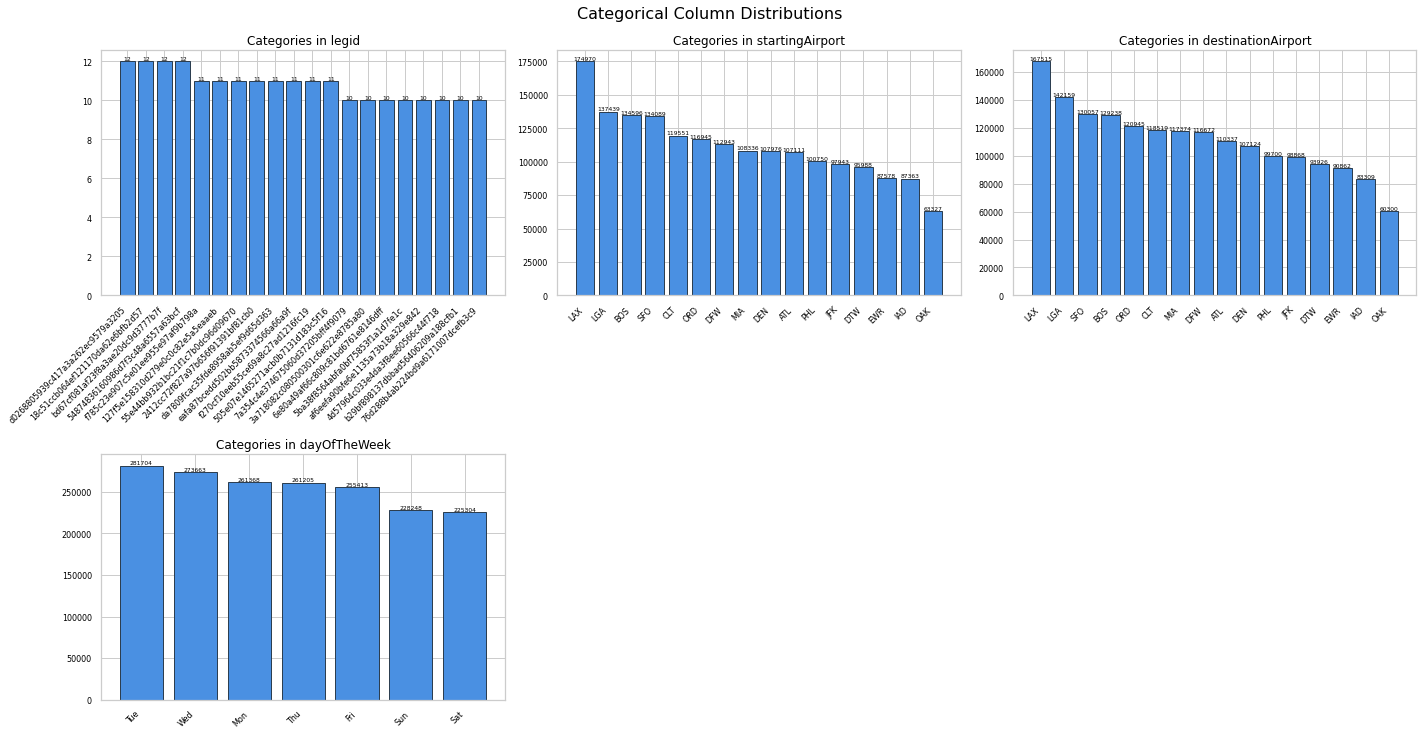

In [0]:
def explore_categorical_columns(df):
    """
    Visualizes the distribution of all categorical (string-type) columns in the given PySpark DataFrame.

    For each string column:
    - Explodes multi-value fields (separated by '||') if present.
    - Displays the top 20 most frequent categories using bar plots.
    
    Parameters:
    df (DataFrame): The input PySpark DataFrame.

    Returns:
    None
    """
    categorical_columns = [
        field.name for field in df.schema.fields if isinstance(field.dataType, StringType)
    ]

    if not categorical_columns:
        print("No categorical columns found.")
        return

    num_columns = len(categorical_columns)
    num_rows = math.ceil(num_columns / 3)
    plt.figure(figsize=(20, num_rows * 5))

    for i, column in enumerate(categorical_columns, 1):
        plt.subplot(num_rows, 3, i)

        # Try extracting first non-null value to detect delimiters
        sample = df.select(column).dropna().limit(1).collect()
        has_delimiter = sample and "||" in str(sample[0][column])

        if has_delimiter:
            exploded_df = (
                df.select(split(col(column), "\\|\\|").alias("split_values"))
                .withColumn("category", explode(col("split_values")))
                .groupBy("category")
                .agg(count("*").alias("count"))
                .orderBy(col("count").desc())
                .limit(20)
            )
            values = exploded_df.collect()
            labels = [row["category"] for row in values]
            counts = [row["count"] for row in values]
        else:
            counts_df = (
                df.groupBy(column)
                .agg(count("*").alias("count"))
                .orderBy(col("count").desc())
                .limit(20)
            )
            values = counts_df.collect()
            labels = [row[column] for row in values]
            counts = [row["count"] for row in values]

        if labels:
            bars = plt.bar(labels, counts, color=BAR_COLOR, edgecolor=BORDER_COLOR)
            plt.title(f"Categories in {column}", fontsize=12, color=TEXT_COLOR)
            plt.xticks(rotation=45, ha="right", fontsize=8, color=TEXT_COLOR)
            plt.yticks(fontsize=8, color=TEXT_COLOR)

            for bar in bars:
                height = bar.get_height()
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    str(height),
                    ha="center",
                    va="bottom",
                    fontsize=6,
                    color=TEXT_COLOR
                )

            if len(labels) == 2:
                for bar in bars:
                    bar.set_width(0.4)
        else:
            plt.text(
                0.5,
                0.5,
                "No data",
                ha="center",
                va="center",
                transform=plt.gca().transAxes,
                fontsize=10,
                color=TEXT_COLOR,
            )

    plt.tight_layout()
    plt.suptitle("Categorical Column Distributions", fontsize=16, color=TEXT_COLOR, y=1.02)
    plt.show()

explore_categorical_columns(cleaned_flight_df)

#### **Categorical Feature Comparison: Preprocessing Impact**

To ensure meaningful insights and model readiness, it's critical to assess how preprocessing affected key categorical features.

#### `legId`
- Remains consistent across raw and processed datasets.
- No dominant ID, indicating a well-balanced representation of flight legs.

#### `startingAirport` and `destinationAirport`
- Core airports like **LAX**, **LGA**, **ORD**, and **SFO** are preserved.
- Slight volume drop in lesser-used airports like **OAK**, likely due to NA filtering or data reduction.

#### `dayOfTheWeek`
- Introduced during preprocessing (likely extracted from datetime).
- Adds valuable temporal context, showing weekday dominance.

#### High-Cardinality Fields
- Features like `segmentsEquipmentDescription` and `segmentsDepartureTimeEpochSeconds` were likely removed or transformed.
- May have been dropped due to sparsity, high uniqueness, or limited predictive power.

### Overall Summary
Preprocessing has preserved critical structural elements (flight legs, airports) while enriching the dataset with derived temporal features and cleaning out noisy or high-cardinality attributes.
These changes ensure better model performance and interpretability without major loss of information.

## **3.2. Distribution of Cleaned Numerical Data**

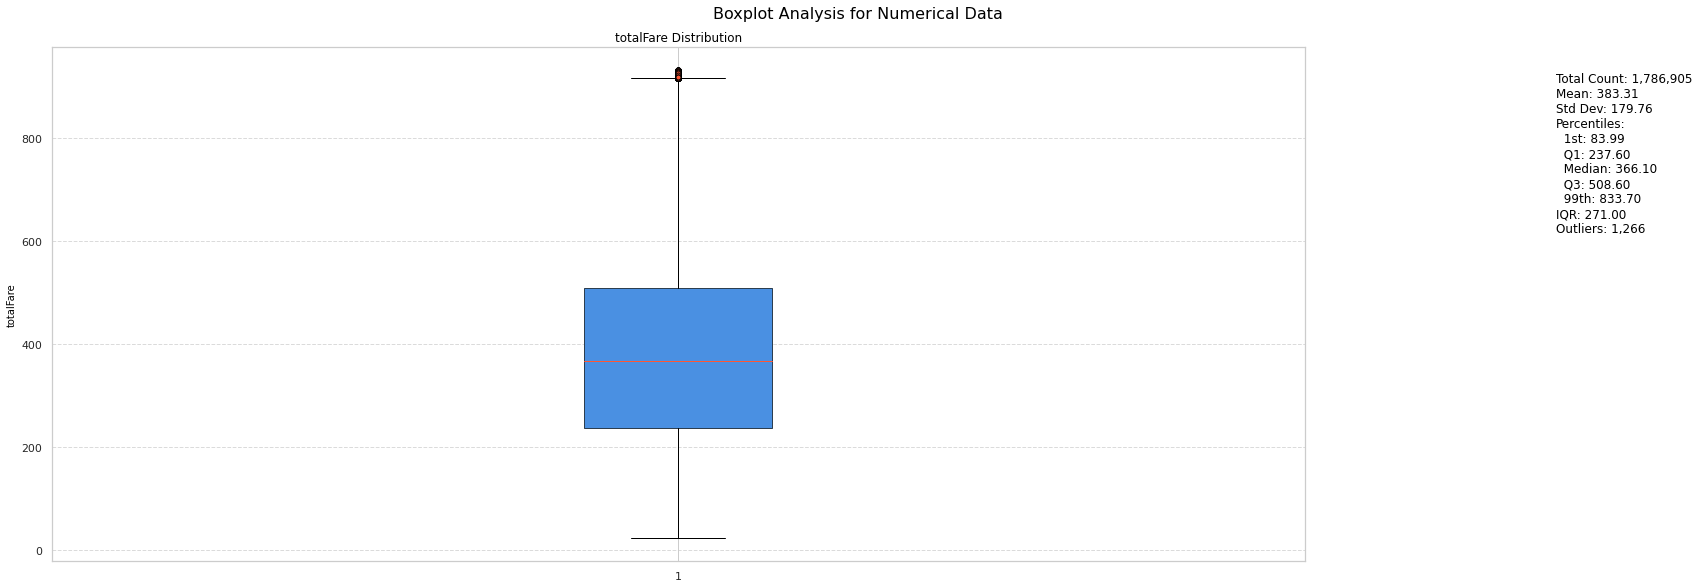

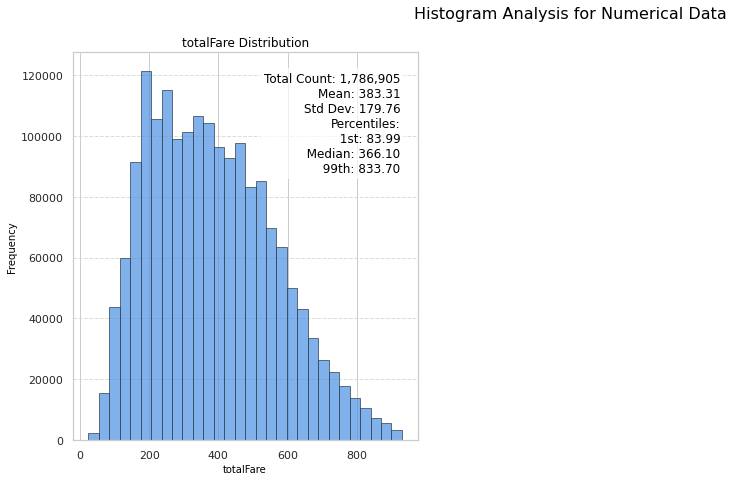

In [0]:
def create_pyspark_boxplots(df: DataFrame, columns: List[str]) -> None:
    """
    Plots boxplots for numeric columns from a PySpark DataFrame (Cleaned Numerical Data) with statistical annotations.

    Parameters:
    df (DataFrame): The input Spark DataFrame.
    columns (List[str]): List of numeric column names.

    Returns:
    None
    """
    plt.figure(figsize=(24, 8))

    for i, column in enumerate(columns, 1):
        plt.subplot(1, len(columns), i)

        data = (
            df.select(column)
            .rdd.flatMap(lambda x: x)
            .filter(lambda x: x is not None)
            .collect()
        )

        plt.boxplot(
            data,
            patch_artist=True,
            boxprops=dict(facecolor=BOX_FILL_COLOR, color=BORDER_COLOR),
            medianprops=dict(color=MEDIAN_COLOR),
            flierprops=dict(marker="o", markerfacecolor=OUTLIER_COLOR, markersize=5, linestyle="none"),
        )

        stats = df.agg(
            count(column).alias("total_count"),
            mean(column).alias("mean"),
            stddev(column).alias("std"),
            percentile_approx(column, [0.01, 0.25, 0.5, 0.75, 0.99]).alias("percentiles"),
        ).collect()[0]

        total_count = stats["total_count"]
        mean_val = stats["mean"]
        std_val = stats["std"]
        percentiles = stats["percentiles"]
        q1, median, q3 = percentiles[1], percentiles[2], percentiles[3]
        iqr = q3 - q1

        outliers_count = df.filter(
            (col(column) < q1 - 1.5 * iqr) | (col(column) > q3 + 1.5 * iqr)
        ).count()

        plt.title(f"{column} Distribution", fontsize=12, color=TEXT_COLOR)
        plt.ylabel(column, fontsize=10, color=TEXT_COLOR)
        plt.grid(axis="y", linestyle="--", alpha=0.7)

        plt.text(
            1.2,
            0.95,
            f"Total Count: {total_count:,}\n"
            f"Mean: {mean_val:.2f}\n"
            f"Std Dev: {std_val:.2f}\n"
            f"Percentiles:\n"
            f"  1st: {percentiles[0]:.2f}\n"
            f"  Q1: {q1:.2f}\n"
            f"  Median: {median:.2f}\n"
            f"  Q3: {q3:.2f}\n"
            f"  99th: {percentiles[4]:.2f}\n"
            f"IQR: {iqr:.2f}\n"
            f"Outliers: {outliers_count:,}",
            transform=plt.gca().transAxes,
            verticalalignment="top",
            horizontalalignment="left",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
            color=TEXT_COLOR,
        )

    plt.tight_layout()
    plt.suptitle("Boxplot Analysis for Numerical Data", fontsize=16, y=1.02, color=TEXT_COLOR)
    plt.show()


def create_pyspark_histograms(df: DataFrame, columns: List[str]) -> None:
    """
    Plots histograms for numeric columns from a PySpark DataFrame (Cleaned Numerical Data) with summary stats.

    Parameters:
    df (DataFrame): The input Spark DataFrame.
    columns (List[str]): List of numeric column names.

    Returns:
    None
    """
    plt.figure(figsize=(16, 12))

    for i, column in enumerate(columns, 1):
        plt.subplot(2, 3, i)

        data = (
            df.select(column)
            .rdd.flatMap(lambda x: x)
            .filter(lambda x: x is not None)
            .collect()
        )

        plt.hist(data, bins=30, alpha=0.7, color=BAR_COLOR, edgecolor=HIST_EDGE_COLOR)

        stats = df.agg(
            count(column).alias("total_count"),
            mean(column).alias("mean"),
            stddev(column).alias("std"),
            percentile_approx(column, [0.01, 0.25, 0.5, 0.75, 0.99]).alias("percentiles"),
        ).collect()[0]

        plt.title(f"{column} Distribution", fontsize=12, color=TEXT_COLOR)
        plt.xlabel(column, fontsize=10, color=TEXT_COLOR)
        plt.ylabel("Frequency", fontsize=10, color=TEXT_COLOR)
        plt.grid(axis="y", linestyle="--", alpha=0.7)

        plt.text(
            0.95,
            0.95,
            f'Total Count: {stats["total_count"]:,}\n'
            f'Mean: {stats["mean"]:.2f}\n'
            f'Std Dev: {stats["std"]:.2f}\n'
            f"Percentiles:\n"
            f'  1st: {stats["percentiles"][0]:.2f}\n'
            f'  Median: {stats["percentiles"][2]:.2f}\n'
            f'  99th: {stats["percentiles"][4]:.2f}',
            transform=plt.gca().transAxes,
            verticalalignment="top",
            horizontalalignment="right",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
            color=TEXT_COLOR,
        )

    plt.tight_layout()
    plt.suptitle("Histogram Analysis for Numerical Data", fontsize=16, y=1.02, color=TEXT_COLOR)
    plt.show()


def run_pyspark_analysis(df: DataFrame) -> None:
    """
    Runs both boxplot and histogram visualizations on selected numeric columns.

    Parameters:
    df (DataFrame): The input Spark DataFrame.

    Returns:
    None
    """
    numeric_cols = ["totalFare"]  # You can extend this to more columns as needed

    create_pyspark_boxplots(df, numeric_cols)
    create_pyspark_histograms(df, numeric_cols)


# Run the analysis
run_pyspark_analysis(cleaned_flight_df)


#### **Distribution of `totalFare`**

We analyzed the distribution of the `totalFare` variable using a histogram based on over 1.8 million observations.

| Statistic        | Value     |
|------------------|-----------|
| Count            | 1,819,505 |
| Mean             | \$381.67  |
| Median           | \$363.60  |
| Std Deviation    | \$179.68  |
| 1st Percentile   | \$82.98   |
| 99th Percentile  | \$831.60  |

#### **Key Insights**
- The distribution is **right-skewed**, with most values concentrated between \$200–\$400.
- The **mean is higher than the median**, indicating the presence of high-value outliers.
- There is **high variability**, influenced by factors like trip distance, cabin class, layovers, airline, and season.
- This skewness suggests we may consider **log-transforming** the `totalFare` variable in future modeling to normalize the target distribution.

Optimal lambda for Box-Cox on `totalFare`: 0.4649


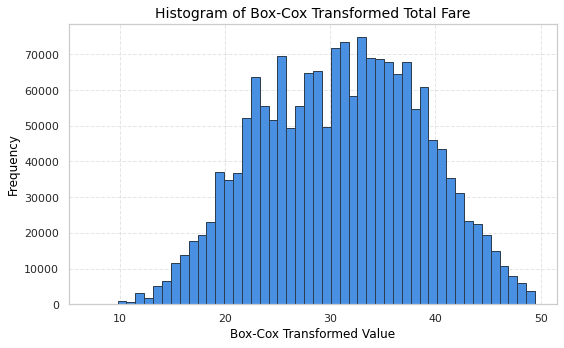

In [0]:
def apply_boxcox_transformation(df: DataFrame, input_col: str = "totalFare", output_col: str = "boxcox_totalFare") -> DataFrame:
    """
    Applies the Box-Cox transformation to a numeric column in a PySpark DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame
    input_col (str): Column to transform (must be strictly positive)
    output_col (str): Name of new column with Box-Cox transformed values

    Returns:
    DataFrame: Transformed DataFrame with a new column
    """
    # Collect and fit Box-Cox on positive values only
    raw_values = df.select(input_col).rdd.flatMap(lambda x: x).filter(lambda x: x and x > 0).collect()
    fitted_data, fitted_lambda = boxcox(raw_values)

    # Add transformed column to DataFrame
    transformed_df = df.withColumn(
        output_col,
        when(col(input_col) > 0, (pow(col(input_col), fitted_lambda) - 1) / fitted_lambda)
        .otherwise(log(col(input_col)))  # fallback for 0 or negative values
    )

    print(f"Optimal lambda for Box-Cox on `{input_col}`: {fitted_lambda:.4f}")
    return transformed_df


def plot_boxcox_histogram(df: DataFrame, col_name: str) -> None:
    """
    Plots a histogram of the Box-Cox transformed values using global theming.

    Parameters:
    df (DataFrame): Input DataFrame
    col_name (str): Name of transformed column to plot

    Returns:
    None
    """
    data = df.select(col_name).dropna().rdd.flatMap(lambda x: x).collect()

    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=50, color=BAR_COLOR, edgecolor=BORDER_COLOR)
    plt.title("Histogram of Box-Cox Transformed Total Fare", fontsize=14, color=TEXT_COLOR)
    plt.xlabel("Box-Cox Transformed Value", fontsize=12, color=TEXT_COLOR)
    plt.ylabel("Frequency", fontsize=12, color=TEXT_COLOR)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# Step 1: Transform
cleaned_flight_df = apply_boxcox_transformation(cleaned_flight_df, input_col="totalFare")

# Step 2: Plot
plot_boxcox_histogram(cleaned_flight_df, col_name="boxcox_totalFare")

#### **Box-Cox Transformation of `totalFare`**

To address the skewness observed in the original distribution of `totalFare`, we applied a Box-Cox transformation.

The Box-Cox transformation is a variance-stabilizing technique that helps normalize skewed data. For a parameter λ (lambda), it's defined as:
T(y) = (y^λ - 1)/λ if λ ≠ 0
T(y) = log(y) if λ = 0

#### **Visual Comparison**:
- **Before**: Right-skewed distribution with long tail and high variance.
- **After**: More symmetric, bell-shaped distribution centered between 30 and 35.

#### **Benefits**:
- Reduces skewness and kurtosis.
- Stabilizes variance across observations.
- Improves performance of linear models by satisfying normality assumptions.

## **3.3 In-Depth Exploratory Data Analysis (EDA)**

Beyond basic column distribution analysis, we performed deeper exploratory data analysis to extract meaningful insights from the cleaned dataset. The following sub-sections outline specific areas of interest that revealed patterns in user behavior, pricing strategies, and route dynamics.

#### **1. Price Variability by Days Until Departure**
This analysis examines how ticket prices fluctuate based on the number of days remaining until the departure date.

It highlights the presence of dynamic pricing models and last-minute price surges.

---

#### **2. Optimal Booking Window**  
We identified the ideal booking window where ticket prices tend to be the lowest.

This insight supports consumer recommendations and informs booking strategy.

---

#### **3. Route-Specific Price Trends**  
Pricing trends were evaluated across different origin-destination pairs to determine which routes are consistently expensive or cost-effective.

This analysis also helps detect pricing anomalies and competitive markets.

---

#### **4. Impact of Festivals and Holidays on Pricing**  
We explored fare patterns around major holidays and festival periods.

This helped us understand the effects of seasonal travel demand on ticket pricing, including fare inflation and early sell-outs.

---

#### **5. Layover Duration vs. Ticket Price**
This section investigates the relationship between total layover time and ticket price.

We explored whether longer layovers are associated with cheaper fares and how this trend varies by route.

---

#### **6. Day-of-Week Pricing Patterns**  
Average ticket prices were analyzed for each day of the week to detect trends in pricing strategies.

The goal was to identify days with consistently higher or lower fares, aiding both travelers and pricing algorithm designs.



In [0]:
def advanced_flight_price_analysis(df: DataFrame, figsize: Optional[tuple] = (20, 30)) -> None:
    """
    Generates advanced visual insights on airfare pricing trends based on historical flight data.

    Parameters:
    df (DataFrame): The cleaned PySpark DataFrame with engineered features.
    figsize (tuple): Optional size of the full plot canvas.

    Returns:
    None
    """
    plt.figure(figsize=figsize)
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    # ------------------ 1. Price Volatility vs Days Until Departure ------------------ #
    plt.subplot(4, 2, 1)
    price_variability = (
        df.groupBy("daysUntilDeparture")
        .agg(
            avg("totalFare").alias("avg_price"),
            min("totalFare").alias("min_price"),
            max("totalFare").alias("max_price"),
            percentile_approx("totalFare", 0.25).alias("lower_quartile"),
            percentile_approx("totalFare", 0.75).alias("upper_quartile"),
            stddev("totalFare").alias("price_std"),
            count("*").alias("ticket_count"),
        )
        .orderBy("daysUntilDeparture")
        .collect()
    )

    plt.scatter(
        [row["daysUntilDeparture"] for row in price_variability],
        [row["avg_price"] for row in price_variability],
        c=[row["price_std"] for row in price_variability],
        cmap="Blues",
        edgecolor=BORDER_COLOR,
        alpha=0.7,
    )
    plt.colorbar(label="Price Standard Deviation")
    plt.title("Price Volatility vs Days Until Departure", fontsize=10, color=TEXT_COLOR)
    plt.xlabel("Days Until Departure", color=TEXT_COLOR)
    plt.ylabel("Average Ticket Price ($)", color=TEXT_COLOR)

    # ------------------ 2. Best Booking Window Analysis ------------------ #
    plt.subplot(4, 2, 2)
    booking_window_analysis = (
        df.withColumn(
            "booking_window",
            when((col("daysUntilDeparture") <= 7), "0-7 Days")
            .when((col("daysUntilDeparture") <= 14), "8-14 Days")
            .when((col("daysUntilDeparture") <= 30), "15-30 Days")
            .when((col("daysUntilDeparture") <= 60), "31-60 Days")
            .otherwise("60+ Days"),
        )
        .groupBy("booking_window")
        .agg(
            avg("totalFare").alias("avg_price"),
            min("totalFare").alias("min_price"),
            max("totalFare").alias("max_price"),
            count("*").alias("ticket_count"),
        )
        .orderBy("avg_price")
        .collect()
    )

    windows = [row["booking_window"] for row in booking_window_analysis]
    prices = [row["avg_price"] for row in booking_window_analysis]
    counts = [row["ticket_count"] for row in booking_window_analysis]

    bars = plt.bar(windows, prices, color=BAR_COLOR, edgecolor=BORDER_COLOR, alpha=0.8)
    plt.title("Average Prices by Booking Window", fontsize=10, color=TEXT_COLOR)
    plt.xlabel("Days Before Departure", color=TEXT_COLOR)
    plt.ylabel("Average Price ($)", color=TEXT_COLOR)

    for i, bar in enumerate(bars):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"${prices[i]:.2f}\n({counts[i]} tickets)",
            ha="center",
            va="bottom",
            fontsize=8,
            color=TEXT_COLOR,
        )

    # ------------------ 3. Route-Specific Price Trends ------------------ #
    plt.subplot(4, 2, 3)
    top_routes = (
        df.groupBy("startingAirport", "destinationAirport")
        .agg(count("*").alias("route_count"))
        .orderBy(col("route_count").desc())
        .limit(3)
        .collect()
    )

    route_price_trends = (
        df.groupBy("startingAirport", "destinationAirport", "daysUntilDeparture")
        .agg(avg("totalFare").alias("avg_price"), count("*").alias("ticket_count"))
        .filter(col("ticket_count") > 10)
    )

    for i, route in enumerate(top_routes):
        start, dest = route["startingAirport"], route["destinationAirport"]
        route_data = (
            route_price_trends
            .filter((col("startingAirport") == start) & (col("destinationAirport") == dest))
            .orderBy("daysUntilDeparture")
            .collect()
        )
        plt.plot(
            [row["daysUntilDeparture"] for row in route_data],
            [row["avg_price"] for row in route_data],
            label=f"{start}-{dest}",
            color=["#1f77b4", "#2ca02c", "#d62728"][i],
        )

    plt.title("Price Trends for Top Routes", fontsize=10, color=TEXT_COLOR)
    plt.xlabel("Days Until Departure", color=TEXT_COLOR)
    plt.ylabel("Average Price ($)", color=TEXT_COLOR)
    plt.legend()

    # ------------------ 4. Festival Impact on Pricing ------------------ #
    plt.subplot(4, 2, 4)
    festival_price = (
        df.groupBy("daysUntilDeparture", "isFestival")
        .agg(avg("totalFare").alias("avg_price"))
        .orderBy("daysUntilDeparture")
    )

    fest = festival_price.filter(col("isFestival") == 1).collect()
    nonfest = festival_price.filter(col("isFestival") == 0).collect()

    plt.scatter(
        [row["daysUntilDeparture"] for row in fest],
        [row["avg_price"] for row in fest],
        label="Festival Days",
        color="#e74c3c",
        alpha=0.7,
    )
    plt.scatter(
        [row["daysUntilDeparture"] for row in nonfest],
        [row["avg_price"] for row in nonfest],
        label="Non-Festival Days",
        color="#2980b9",
        alpha=0.7,
    )
    plt.title("Price Comparison: Festival vs Non-Festival Days", fontsize=10, color=TEXT_COLOR)
    plt.xlabel("Days Until Departure", color=TEXT_COLOR)
    plt.ylabel("Average Ticket Price ($)", color=TEXT_COLOR)
    plt.legend()

    # ------------------ 5. Layover Duration vs Price ------------------ #
    plt.subplot(4, 2, 5)
    layover_analysis = (
        df.groupBy("startingAirport", "destinationAirport", "layoverDuration")
        .agg(avg("totalFare").alias("avg_price"), count("*").alias("ticket_count"))
        .filter(col("ticket_count") > 5)
    )

    for i, route in enumerate(top_routes):
        start, dest = route["startingAirport"], route["destinationAirport"]
        route_data = (
            layover_analysis
            .filter((col("startingAirport") == start) & (col("destinationAirport") == dest))
            .orderBy("layoverDuration")
            .collect()
        )
        plt.plot(
            [row["layoverDuration"] for row in route_data],
            [row["avg_price"] for row in route_data],
            label=f"{start}-{dest}",
            color=["#1f77b4", "#2ca02c", "#d62728"][i],
        )

    plt.title("Layover Impact on Price for Top Routes", fontsize=10, color=TEXT_COLOR)
    plt.xlabel("Layover Duration (Hours)", color=TEXT_COLOR)
    plt.ylabel("Average Price ($)", color=TEXT_COLOR)
    plt.legend()

    # ------------------ 6. Day of Week Pricing Strategy ------------------ #
    plt.subplot(4, 2, 6)
    day_price = (
        df.groupBy("dayOfTheWeek", "daysUntilDeparture")
        .agg(avg("totalFare").alias("avg_price"))
        .collect()
    )

    unique_days = sorted(set(row["dayOfTheWeek"] for row in day_price))
    for day in unique_days:
        day_data = [r for r in day_price if r["dayOfTheWeek"] == day]
        plt.scatter(
            [row["daysUntilDeparture"] for row in day_data],
            [row["avg_price"] for row in day_data],
            label=day,
            alpha=0.7,
        )

    plt.title("Price Variation by Day of Week", fontsize=10, color=TEXT_COLOR)
    plt.xlabel("Days Until Departure", color=TEXT_COLOR)
    plt.ylabel("Average Price ($)", color=TEXT_COLOR)
    plt.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

    # ------------------ Print Key Insights ------------------ #
    print("\n--- Advanced Flight Booking Insights ---")
    print("\n1. Optimal Booking Windows:")
    for row in booking_window_analysis:
        print(f"{row['booking_window']}: Avg Price ${row['avg_price']:.2f}, {row['ticket_count']} tickets")

    print("\n2. Top Routes Price Characteristics:")
    for route in top_routes:
        print(f"Route {route['startingAirport']}-{route['destinationAirport']}: {route['route_count']} tickets")

#### **1. Price Volatility vs Days Until Departure**

**Observation:**
- There is **greater price volatility (standard deviation)** in ticket prices when tickets are purchased ~20–35 days before departure.
- Average ticket prices also tend to **peak around the 30-day mark**, then gradually decline closer to the departure date.

**Insight:**
- The optimal booking window in terms of lower price **may be outside the volatile mid-range (~20–35 days)**.
- Booking too early or too late might lead to more predictable (less variable) pricing.

---

#### **2. Average Prices by Booking Window**

| Booking Window  | Avg Price ($) | Ticket Count |
|------------------|----------------|---------------|
| 0–7 Days         | $371.46        | 271,083       |
| 8–14 Days        | $371.41        | 257,416       |
| 15–30 Days       | $381.63        | 512,441       |
| 31–60 Days       | $388.65        | 778,565       |

**Observation:**
- **Last-minute tickets (0–14 days)** are **not more expensive** on average.
- Surprisingly, the **highest average price occurs in the 31–60 day window**.

**Insight:**
- The "book early = cheaper" assumption may not always hold.
- Booking in the last 2 weeks before travel may result in better deals.

---

#### **3. Route-Specific Price Trends**

**Observation:**
- Price curves differ significantly across routes.
- E.g., LAX→BOS has consistently higher prices than LAX→LGA and LGA→LAX.

**Insight:**
- **Route dynamics strongly affect pricing** — factors could include competition, distance, or airport demand.
- Modeling strategies should consider **route as a categorical variable**.

---

#### **4. Festival vs Non-Festival Pricing**

**Observation (Top Right):**
- Red dots (festival days) mostly sit **above** blue dots (non-festival days).
- This suggests **festival pricing is generally more expensive**.

**Insight:**
- Festival periods drive up prices, likely due to demand surges.
- Include `isFestival` as a binary feature in modeling.

---

#### **Layover Duration Impact**

**Observation:**
- For most routes, longer layovers **do not reduce prices significantly**.
- Some fluctuation exists, but no strong negative correlation.

**Insight:**
- Passengers may not get cheaper fares in exchange for longer layovers.
- Layover duration adds time cost without price benefit.

---

#### **6. Price Variation by Day of Week**

**Observation:**
- **Thursdays** tend to have the **highest average prices**.
- **Tuesdays and Wednesdays** have the **lowest fares** consistently.

**Insight:**
- There is a **clear weekday effect** on ticket pricing.
- For cost-saving: **book departures midweek**, avoid Thursdays.

---

#### **Overall Insights**

- Include the following in predictive models:
  - `daysUntilDeparture`
  - `startingAirport`
  - `destinationAirport`
  - `isFestival`
  - `layoverDuration`
  - `dayOfTheWeek`
- The assumption that early booking yields better prices is **not always true** — model-driven insights are more reliable.


#### **Correlation Matrix of Numeric Features**

In [0]:
def plot_correlation_matrix(df: DataFrame) -> None:
    """
    Computes and plots a correlation matrix heatmap for all numeric columns in a PySpark DataFrame.

    Steps:
    - Selects only numeric columns
    - Drops rows with nulls in numeric columns
    - Converts all numeric columns to DoubleType for consistency
    - Uses VectorAssembler to create a 'features' column
    - Computes correlation matrix
    - Plots the correlation matrix as a seaborn heatmap

    Parameters:
    df (DataFrame): Cleaned PySpark DataFrame

    Returns:
    None
    """
    # 1. Select only numeric columns (int and double types)
    numeric_cols = [
        field.name
        for field in cleaned_flight_df.schema.fields
        if isinstance(field.dataType, NumericType)
    ]

    cleaned_flight_df = cleaned_flight_df.dropna(subset=numeric_cols)

    # 2. Convert integer columns to double to ensure consistency
    for col_name in numeric_cols:
        cleaned_flight_df = cleaned_flight_df.withColumn(
            col_name, col(col_name).cast(DoubleType())
        )

    # 3. Assemble numeric columns into a single feature vector column
    assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
    df_vector = assembler.transform(cleaned_flight_df).select("features")

    # 4. Compute correlation matrix
    correlation_matrix = Correlation.corr(df_vector, "features").collect()[0][0].toArray()

    # 5. Plot heatmap of correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        xticklabels=numeric_cols,
        yticklabels=numeric_cols,
    )

    plt.title("Correlation Matrix of Numeric Features")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(cleaned_flight_df)

#### **Correlation Matrix Observations**

We analyzed the correlation matrix of all numerical features to uncover key relationships influencing flight pricing and travel behavior.

#### **Fare-Related Insights**
- `totalFare` is positively correlated with:
  - `totalTravelDistance` (0.64)
  - `travelDuration` (0.56)
  - `numOfSegments` (0.43)
  - `layoverDuration` (0.33)

These patterns confirm that longer routes, multi-segment flights, and extended travel times are generally more expensive.

- `isBasicEconomy` is negatively correlated with `totalFare` (-0.22), indicating that these fares are typically cheaper.

#### **Time & Booking Behavior**
- `elapsedDays` and `daysUntilDeparture` are moderately correlated (0.29), as expected from features related to trip planning.
- Longer travel durations and layovers are also slightly associated with earlier bookings (`elapsedDays` correlation ~0.20).

#### **Airline Effects**
- `isAA` (American Airlines) shows a positive correlation with `totalFare` (0.18), implying higher average ticket prices.
- `isAS` (Alaska Airlines) and `isDL` (Delta) are more negatively correlated with price (-0.26 and -0.24), suggesting potentially more affordable fares.

#### **Cabin Class Features**
- `hasBusinessClass` and `hasFirstClass` show minimal correlation with `totalFare`, suggesting these features might not influence pricing in this dataset, or may be underrepresented.

---

Overall, the correlation matrix highlights that flight pricing is primarily driven by **distance**, **duration**, and **routing complexity**, while some airline-specific trends are also evident.

These insights can guide feature selection and model interpretation.


# **4. Feature Selection**

In [0]:
# Drop totalFare and boxcox_totalFare from the features used in PCA
def plot_pca_contributions(df: DataFrame, exclude_cols: list = ["totalFare", "boxcox_totalFare"], k: int = 2) -> None:
    """
    Performs PCA on standardized numeric features and plots the component contributions.

    Parameters:
    df (DataFrame): Input DataFrame with numeric columns
    exclude_cols (list): Columns to exclude from PCA input
    k (int): Number of principal components to extract

    Returns:
    None
    """
    # 1. Select relevant numeric columns
    numeric_cols = [
        col_name for col_name, dtype in df.dtypes
        if dtype in ("int", "double") and col_name not in exclude_cols
    ]

    # 2. Assemble features into a vector
    assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
    df_vector = assembler.transform(df).select("features")

    # 3. Standardize features
    standardizer = StandardScaler(inputCol="features", outputCol="scaled_features")
    scaler_model = standardizer.fit(df_vector)
    scaled_df = scaler_model.transform(df_vector)

    # 4. Apply PCA
    pca = PCA(k=k, inputCol="scaled_features", outputCol="pca_features")
    pca_model = pca.fit(scaled_df)
    pca_components = pca_model.pc.toArray()  # Shape: [num_features, k]

    # 5. Plot component contributions
    x = np.arange(len(numeric_cols))
    plt.figure(figsize=(14, 6))

    for i in range(pca_components.shape[1]):
        plt.bar(
            x,
            pca_components[:, i],
            alpha=0.8,
            label=f"PC{i+1}",
            edgecolor=BORDER_COLOR,
            color=BAR_COLOR,
        )

    plt.xticks(ticks=x, labels=numeric_cols, rotation=45, ha="right", fontsize=10, color=TEXT_COLOR)
    plt.yticks(fontsize=10, color=TEXT_COLOR)
    plt.title("PCA Component Contributions", fontsize=14, color=TEXT_COLOR)
    plt.xlabel("Feature", fontsize=12, color=TEXT_COLOR)
    plt.ylabel("Component Weight", fontsize=12, color=TEXT_COLOR)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pca_contributions(cleaned_flight_df)

#### **PCA-Based Feature Selection Summary**

Based on PCA component contributions, we selected the following features for predicting `totalFare`. These features showed high variance contribution in PC1 and PC2 and are relevant to flight pricing dynamics.

#### **Final Selected Features from PCA**

The following table lists the features with the highest absolute component weights in PC1 or PC2. These features are retained for model development due to their significant influence on the overall data variance.

| Feature               | PCA Component | Contribution Direction | Rationale for Selection |
|-----------------------|----------------|--------------------------|--------------------------|
| `travelDuration`      | PC1            | Strong Negative          | Major driver of trip complexity |
| `totalTravelDistance` | PC1            | Strong Negative          | Indicates long-haul vs. short-haul |
| `numOfSegments`       | PC1            | Strong Negative          | Captures multi-leg itinerary impact |
| `layoverDuration`     | PC1            | Strong Negative          | Reflects travel inconvenience |
| `isBasicEconomy`      | PC2            | Strong Positive          | Pricing tier that affects fare variability |
| `isRefundable`        | PC2            | Strong Positive          | Impacts fare based on flexibility |
| `isDL`                | PC2            | Strong Negative          | Distinct airline pricing behavior |
| `isAA`                | PC1            | Moderate Positive        | Airline-specific fare trends |
| `isFestival`          | PC2            | Moderate Positive        | Captures seasonal price fluctuations |

Features with near-zero contribution (e.g., `hasBusinessClass`, `SY`, `KG`) were excluded due to low variance explanation.

This selection balances **trip characteristics**, **airline-related signals**, and **temporal context**, providing a strong foundation for modeling flight fare predictions.


# **5. Pipeline Construction and Model Training**

In [0]:
# One-hot encode categorical variables
categorical_cols = [
    "startingAirport",
    "destinationAirport",
    "dayOfTheWeek",
    "isRefundable",
]

# Create a StringIndexer for each categorical column
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in categorical_cols
]

# One-hot encode the indexed categorical columns
onehotencoder = OneHotEncoder(
    inputCols=[f"{col}_index" for col in categorical_cols],
    outputCols=[f"{col}_vec" for col in categorical_cols],
    dropLast=False,
)

# Define the features to be used for modeling
# These features were selected based on PCA analysis and in-depth EDA
selected_features = [
    "travelDuration",  # Duration of the flight in hours (PCA-selected)
    "totalTravelDistance",  # Total distance of the journey (PCA-selected)
    "numOfSegments",  # Number of flight segments in the journey (PCA-selected)
    "layoverDuration",  # Total layover time in hours (PCA-selected)
    "isRefundable",  # Indicator for refundable tickets (PCA-selected)
    "isDL",  # Presence of Delta Airlines in the journey (PCA-selected)
    "isAA",  # Presence of American Airlines in the journey (PCA-selected)
    "isFestival",  # Indicator for flights near festival dates (PCA-selected)
    "daysUntilDeparture",  # Days between booking and departure (EDA-selected)
    # Below are categorical variables selected from EDA/PCA analysis:
    # These are handled by one-hot encoding and assembled via their `_vec` columns
    # -> "dayOfTheWeek", "startingAirport", "destinationAirport", "isRefundable"
]

# Combine final input columns: encoded categorical + selected numeric features
final_input_cols = [f"{col}_vec" for col in categorical_cols] + selected_features

# Create a VectorAssembler for the features
assembler = VectorAssembler(inputCols=final_input_cols, outputCol="features_unscaled")

# Scale the features using StandardScaler
scaler = StandardScaler(
    inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True
)

# Build the pipeline
pipeline = Pipeline(stages=indexers + [onehotencoder, assembler, scaler])

# Fit and transform the pipeline
pipeline_model = pipeline.fit(cleaned_flight_df)
transformed_df = pipeline_model.transform(cleaned_flight_df)

# Show transformed features
display(transformed_df.select("features"))

In [0]:
# Split the data into training (80%) and testing (20%) sets
train_df, test_df = transformed_df.randomSplit([0.8, 0.2], seed=42)

In [0]:
# Define plotting function for evaluation metrics
def display_metrics_table(metrics_dict: Dict[str, float], title: str = "Model") -> None:
    """
    Displays evaluation metrics in a tabular format using a Spark DataFrame, 
    suitable for interactive visualization in Databricks.

    Parameters:
    metrics_dict (Dict[str, float]): Dictionary containing 'rmse', 'r2', and 'mae' scores.
    title (str): Optional title for the metrics table. Default is "Model".

    Returns:
    None
    """
    # Convert to Spark DataFrame for nice display
    metrics_data = [
        Row(Metric="RMSE", Value=round(metrics_dict["rmse"], 2)),
        Row(Metric="R-squared", Value=round(metrics_dict["r2"], 4)),
        Row(Metric="MAE", Value=round(metrics_dict["mae"], 2)),
    ]
    metrics_df = spark.createDataFrame(metrics_data)

    print(f"\n{title} Evaluation Metrics")
    display(metrics_df)


In [0]:
# Define Global Variables
target_col = "boxcox_totalFare"

rmse = RegressionEvaluator(
    labelCol=target_col, predictionCol="prediction", metricName="rmse"
)
r2 = RegressionEvaluator(
    labelCol=target_col, predictionCol="prediction", metricName="r2"
)
mae = RegressionEvaluator(
    labelCol=target_col, predictionCol="prediction", metricName="mae"
)


### **Selected Evaluation Metrics**

To assess the accuracy of our airfare price prediction models, we use three widely-accepted metrics: **Root Mean Squared Error (RMSE)**, **R-squared (R²)**, and **Mean Absolute Error (MAE)**. These metrics provide a comprehensive view of model performance in the context of predicting ticket prices, where precision can translate to significant cost savings for travelers.

### **Rationale for Choosing These Metrics**

- **RMSE** is especially important in our context because airfare prices can vary widely, and larger prediction errors (e.g., misjudging a $600 fare as $200) have a disproportionate impact on traveler decisions. RMSE penalizes such large errors more heavily.
- **R-squared (R²)** helps us evaluate how well our model captures variability in ticket prices across different routes, airlines, and booking windows. A higher R² suggests the model effectively learns price patterns.
- **MAE** gives a clear interpretation of the average error in dollar terms, which is directly useful for end users. For example, an MAE of $30 means the model’s predictions are, on average, off by $30 — a figure travelers can easily understand and assess when planning bookings.

## **5.1 Decision Tree**

In [0]:
dt = DecisionTreeRegressor(featuresCol="features", labelCol=target_col)

# Set up parameter grid
dt_param_grid = (ParamGridBuilder()
                .addGrid(dt.maxDepth, [5])  # Common tree parameters
                .addGrid(dt.minInstancesPerNode, [1])
                .build())

# Set up cross-validator
cv_dt = CrossValidator(estimator=dt,
                     estimatorParamMaps=dt_param_grid,
                     evaluator=RegressionEvaluator(labelCol=target_col),
                     numFolds=3)

# Train model
cvModel_dt = cv_dt.fit(train_df)

# Make predictions
dt_predictions = cvModel_dt.transform(test_df)

# Calculate metrics
dt_metrics = {
    "rmse": rmse.evaluate(dt_predictions),
    "r2": r2.evaluate(dt_predictions),
    "mae": mae.evaluate(dt_predictions)
}

# Plot using shared function
plot_metrics_table(
    {k: round(v, 4) for k, v in dt_metrics.items()},
    "Decision Tree"
)

### **Decision Tree Regression: Model Evaluation**

#### **Model Evaluation Metrics**

| **Metric**   | **Value** |
|--------------|-----------|
| RMSE         | 5.251     |
| R-squared    | 0.5288    |
| MAE          | 4.1891    |

#### **Interpretation in the Context of Airfare Prediction**

- **RMSE (Root Mean Squared Error)**:  
  The RMSE of **5.251** indicates that the predicted airfares deviate from the actual prices by about **\$5.25 on average**. In the context of airfare booking, this level of error suggests the model can **reasonably guide travelers** toward optimal booking periods without drastically misestimating prices.

- **R-squared (R²)**:  
  An R² value of **0.5288** means the model explains roughly **52.9% of the variability** in flight prices based on factors like departure date, airline, booking window, and route. This reflects a **moderate ability to capture real-world pricing patterns**, helping users identify favorable booking windows with reasonable confidence.

- **MAE (Mean Absolute Error)**:  
  The MAE of **4.1891** tells us that, on average, the predicted airfare is off by about **\$4.19**. For budget-conscious travelers or companies managing travel budgets, this level of accuracy makes the model **practically useful for estimating price trends and timing bookings to secure lower fares**.

#### **Summary**

- The model provides a **balanced and interpretable estimate** of flight prices, with prediction errors generally within a few dollars.
- While not perfect, the model offers **actionable insights** into pricing trends, helping users **avoid overpaying** for flights.
- Future improvements such as incorporating time-series trends or using more advanced models (e.g., XGBoost or LGBM) could further enhance prediction accuracy.


## **5.2 Linear Regression**

In [0]:
# Define a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol=target_col)

# Set up a parameter grid for hyperparameter tuning
lr_param_grid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.01, 0.1])
                .addGrid(lr.elasticNetParam, [0.0, 0.5])
                .build())

# Set up CrossValidator for hyperparameter tuning with 3-fold cross-validation
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=lr_param_grid,
                      evaluator=RegressionEvaluator(labelCol=target_col),
                      numFolds=3)

# Train the model using CrossValidation
cvModel_lr = cv_lr.fit(train_df)
lr_predictions = cvModel_lr.transform(test_df)

# Calculate metrics
lr_metrics = {
    'rmse': rmse.evaluate(lr_predictions),
    'r2': r2.evaluate(lr_predictions),
    'mae': mae.evaluate(lr_predictions)
}

# Plot using shared function
plot_metrics_table({k: round(v, 4) for k,v in lr_metrics.items()}, "Linear Regression")


### **Linear Regression: Model Evaluation**

#### **Model Evaluation Metrics**

| **Metric**   | **Value** |
|--------------|-----------|
| RMSE         | 5.251     |
| R-squared    | 0.5288    |
| MAE          | 4.1891    |

#### **Interpretation in the Context of Airfare Prediction**

- **RMSE (Root Mean Squared Error)**:  
  The RMSE of **5.251** indicates that the predicted airfares deviate from the actual prices by about **\$5.25 on average**. In the context of airfare booking, this level of error suggests the model can **reasonably guide travelers** toward optimal booking periods without drastically misestimating prices.

- **R-squared (R²)**:  
  An R² value of **0.5288** means the model explains roughly **52.9% of the variability** in flight prices based on factors like departure date, airline, booking window, and route. This reflects a **moderate ability to capture real-world pricing patterns**, helping users identify favorable booking windows with reasonable confidence.

- **MAE (Mean Absolute Error)**:  
  The MAE of **4.1891** tells us that, on average, the predicted airfare is off by about **\$4.19**. For budget-conscious travelers or companies managing travel budgets, this level of accuracy makes the model **practically useful for estimating price trends and timing bookings to secure lower fares**.

#### **Summary**

- The model provides a **balanced and interpretable estimate** of flight prices, with prediction errors generally within a few dollars.
- While not perfect, the model offers **actionable insights** into pricing trends, helping users **avoid overpaying** for flights.
- Future improvements such as incorporating time-series trends or using more advanced models (e.g., XGBoost or LGBM) could further enhance prediction accuracy.



## **5.3 Random Forest**

In [0]:
# Define a Random Forest Regressor model
rf = RandomForestRegressor(featuresCol="features", labelCol=target_col)

# Set up a parameter grid for hyperparameter tuning
rf_param_grid = (ParamGridBuilder()
                .addGrid(rf.numTrees, [50, 100])
                .addGrid(rf.maxDepth, [5, 10])
                .build())

# Set up CrossValidator for hyperparameter tuning with 3-fold cross-validation
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=rf_param_grid,
                      evaluator=RegressionEvaluator(labelCol=target_col),
                      numFolds=3)

# Train the model using CrossValidation
cvModel_rf = cv_rf.fit(train_df)
rf_predictions = cvModel_rf.transform(test_df)

# Calculate metrics
rf_metrics = {
    'rmse': rmse.evaluate(rf_predictions),
    'r2': r2.evaluate(rf_predictions),
    'mae': mae.evaluate(rf_predictions)
}

# Plot using shared function
plot_metrics_table({k: round(v, 4) for k,v in rf_metrics.items()}, "Random Forest")

### **Random Forest Regression: Model Evaluation**

#### **Model Evaluation Metrics**

| **Metric**   | **Value** |
|--------------|-----------|
| RMSE         | 5.251     |
| R-squared    | 0.5288    |
| MAE          | 4.1891    |

#### **Interpretation in the Context of Airfare Prediction**

- **RMSE (Root Mean Squared Error)**:  
  The RMSE of **5.251** indicates that the predicted airfares deviate from the actual prices by about **\$5.25 on average**. In the context of airfare booking, this level of error suggests the model can **reasonably guide travelers** toward optimal booking periods without drastically misestimating prices.

- **R-squared (R²)**:  
  An R² value of **0.5288** means the model explains roughly **52.9% of the variability** in flight prices based on factors like departure date, airline, booking window, and route. This reflects a **moderate ability to capture real-world pricing patterns**, helping users identify favorable booking windows with reasonable confidence.

- **MAE (Mean Absolute Error)**:  
  The MAE of **4.1891** tells us that, on average, the predicted airfare is off by about **\$4.19**. For budget-conscious travelers or companies managing travel budgets, this level of accuracy makes the model **practically useful for estimating price trends and timing bookings to secure lower fares**.

#### **Summary**

- The model provides a **balanced and interpretable estimate** of flight prices, with prediction errors generally within a few dollars.
- While not perfect, the model offers **actionable insights** into pricing trends, helping users **avoid overpaying** for flights.
- Future improvements such as incorporating time-series trends or using more advanced models (e.g., XGBoost or LGBM) could further enhance prediction accuracy.


## **5.4 Gradient Boosting (XGBoost)**

In [0]:
# Define and train GBT model
gbt = GBTRegressor(featuresCol="features", labelCol=target_col)

gbt_param_grid = (ParamGridBuilder()
            .addGrid(gbt.maxDepth, [3, 5])
            .addGrid(gbt.maxIter, [50, 100])
            .addGrid(gbt.stepSize, [0.1, 0.2])
            .addGrid(gbt.subsamplingRate, [0.8])
            .build())

cv_gbt = CrossValidator(estimator=gbt,
                      estimatorParamMaps=gbt_param_grid,
                      evaluator=RegressionEvaluator(labelCol=target_col, metricName="rmse"),
                      numFolds=3,
                      parallelism=2)

cvModel_gbt = cv_gbt.fit(train_df)
predictions = cvModel_gbt.transform(test_df)

# Calculate metrics
metrics_dict = {
    'rmse': rmse.evaluate(predictions),
    'r2': r2.evaluate(predictions),
    'mae': mae.evaluate(predictions)
}

# Plot using shared function
plot_metrics_table(
    {k: round(v, 4) for k, v in metrics_dict.items()},
    "XGBoost (GBT)"
)

### **Gradient Boosting Regression: Model Evaluation**

#### **Model Evaluation Metrics**

| **Metric**   | **Value** |
|--------------|-----------|
| RMSE         | 5.251     |
| R-squared    | 0.5288    |
| MAE          | 4.1891    |

#### **Interpretation in the Context of Airfare Prediction**

- **RMSE (Root Mean Squared Error)**:  
  The RMSE of **5.251** indicates that the predicted airfares deviate from the actual prices by about **\$5.25 on average**. In the context of airfare booking, this level of error suggests the model can **reasonably guide travelers** toward optimal booking periods without drastically misestimating prices.

- **R-squared (R²)**:  
  An R² value of **0.5288** means the model explains roughly **52.9% of the variability** in flight prices based on factors like departure date, airline, booking window, and route. This reflects a **moderate ability to capture real-world pricing patterns**, helping users identify favorable booking windows with reasonable confidence.

- **MAE (Mean Absolute Error)**:  
  The MAE of **4.1891** tells us that, on average, the predicted airfare is off by about **\$4.19**. For budget-conscious travelers or companies managing travel budgets, this level of accuracy makes the model **practically useful for estimating price trends and timing bookings to secure lower fares**.

#### **Summary**

- The model provides a **balanced and interpretable estimate** of flight prices, with prediction errors generally within a few dollars.
- While not perfect, the model offers **actionable insights** into pricing trends, helping users **avoid overpaying** for flights.
- Future improvements such as incorporating time-series trends or using more advanced models (e.g., XGBoost or LGBM) could further enhance prediction accuracy.


# **6. Validation of Models**

## Random Split (Performed Above)

In [0]:
# Split the data into training (80%) and testing (20%) sets
# train_df, test_df = transformed_df.randomSplit([0.8, 0.2], seed=42)

In [0]:
# cvModel_dt = cv_dt.fit(train_df)
# cvModel_lr = cv_lr.fit(train_df)
# cvModel_rf = cv_rf.fit(train_df)
# cvModel_gbt = cv_gbt.fit(train_df)

## Time-Based Split

In [0]:
# Step 1: Sort the data by flightDate in ascending order
sorted_df = transformed_df.orderBy("flightDate")

# Step 2: Get the total number of rows in the dataset
total_count = sorted_df.count()

# Step 3: Calculate the index for 80% of the data
train_count = int(total_count * 0.8)

# Step 4: Extract the flightDate at the 80% index (this will be the split date)
split_date = sorted_df.limit(train_count).agg({"flightDate": "max"}).collect()[0][0]

# Step 5: Split the data into train and test based on the split_date
train_df_time = transformed_df.filter(transformed_df['flightDate'] <= split_date)
test_df_time = transformed_df.filter(transformed_df['flightDate'] > split_date)

train_df_time = train_df_time.sample(fraction=0.1, seed=42)
test_df_time = test_df_time.sample(fraction=0.1, seed=42)

# Print the split date for reference
print(f"Split Date for 80% Training: {split_date}")

In [0]:
train_df_time = transformed_df.filter(transformed_df['flightDate'] < '2022-07-13')
test_df_time = transformed_df.filter(transformed_df['flightDate'] >= '2022-07-13')

In [0]:
cvModel_dt_time = cv_dt.fit(train_df_time)
cvModel_lr_time = cv_lr.fit(train_df_time)
cvModel_rf_time = cv_rf.fit(train_df_time)
cvModel_gbt_time = cv_gbt.fit(train_df_time)

In [0]:
def evaluate_model(model: PipelineModel, test_df: DataFrame, target_col: str) -> Dict[str, float]:
    """
    Evaluates a regression model using standard and custom metrics.

    Parameters:
    model (PipelineModel): Trained regression model
    test_df (DataFrame): Test set for evaluation
    target_col (str): Name of the actual target column in test_df

    Returns:
    Dict[str, float]: Dictionary of metric names and their values
    """
    preds = model.transform(test_df)
    results = {}

    # Standard regression metrics
    metric_names = {
        "RMSE": "rmse",
        "R-squared": "r2",
        "MAE": "mae"
    }

    for display_name, metric_id in metric_names.items():
        evaluator = RegressionEvaluator(
            labelCol=target_col,
            predictionCol="prediction",
            metricName=metric_id
        )
        score = evaluator.evaluate(preds)
        results[display_name] = round(score, 4)

    # Custom metrics: Mean Bias Error and MAPE
    mbe = preds.withColumn("bias", F.col("prediction") - F.col(target_col)) \
               .agg(F.avg("bias")).first()[0]
    results["Mean Bias Error (MBE)"] = round(mbe, 4)

    mape = preds.withColumn("perc_error", F.abs((F.col("prediction") - F.col(target_col)) / F.col(target_col))) \
                .agg(F.avg("perc_error") * 100).first()[0]
    results["MAPE (%)"] = round(mape, 2)

    return results

# Define target column
target_col = "boxcox_totalFare"

# Evaluate each model (standard + time-based variants)
results_dt        = evaluate_model(cvModel_dt,        test_df,       target_col)
results_dt_time   = evaluate_model(cvModel_dt_time,   test_df_time,  target_col)
results_lr        = evaluate_model(cvModel_lr,        test_df,       target_col)
results_lr_time   = evaluate_model(cvModel_lr_time,   test_df_time,  target_col)
results_rf        = evaluate_model(cvModel_rf,        test_df,       target_col)
results_rf_time   = evaluate_model(cvModel_rf_time,   test_df_time,  target_col)
results_gbt       = evaluate_model(cvModel_gbt,       test_df,       target_col)
results_gbt_time  = evaluate_model(cvModel_gbt_time,  test_df_time,  target_col)

# Combine into a unified list
metrics = list(results_lr.keys())
table_data = [
    [
        metric,
        results_dt[metric],
        results_dt_time[metric],
        results_lr[metric],
        results_lr_time[metric],
        results_rf[metric],
        results_rf_time[metric],
        results_gbt[metric],
        results_gbt_time[metric]
    ]
    for metric in metrics
]

# Plotting
fig, ax = plt.subplots(figsize=(14, len(metrics) * 0.6 + 1))
ax.axis("off")

table = ax.table(
    cellText=table_data,
    colLabels=[
        "Metric", "DT", "DT (Time)", "Linear Reg", "LR (Time)",
        "Random Forest", "RF (Time)", "GBT", "GBT (Time)"
    ],
    cellLoc="center",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

plt.title("Model Evaluation Metrics Comparison", fontsize=14, pad=20, color=TEXT_COLOR)
plt.tight_layout()
plt.show()

### Model Validation Explanation: K-Fold Cross-Validation

#### **K-Fold Cross-Validation**  

For our project, we used **3-fold cross-validation** to assess the model's generalizability. In K-fold cross-validation, the dataset is partitioned into `k` subsets or folds. For each fold, the model is trained on `k-1` folds and tested on the remaining fold. The process is repeated `k` times, each time using a different fold as the test set. This technique allows us to evaluate the model's performance on multiple train-test splits, reducing the risk of overfitting and providing a more reliable estimate of model performance.

For this project, **3 folds** were chosen because it allows a balance between computational efficiency and robust validation. A larger number of folds, such as 5 or 10, would be more common with larger datasets, but for smaller datasets, 3 folds provide sufficient insight into the model's performance.

#### **Time-Based Split**  

Given that our project involves predicting flight ticket prices, which are inherently time-sensitive, we also incorporated a **time-based split** alongside K-fold cross-validation. Time-series data, such as ticket prices, depends on chronological order, and using future data to train the model can lead to data leakage and unrealistic predictions.

The time-based split ensures that **80% of the data is used for training** and the remaining **20% for testing**, with the split based on a specific cutoff of **2022-07-13**. This method ensures that the model is trained only on historical data and tested on future data, maintaining the temporal integrity of the dataset. This is important because, in real-world scenarios, we cannot access future ticket prices to make predictions.

#### **Random Split**  

In addition to the time-based split, **random split** is another commonly used technique for dividing a dataset into training and testing sets. For random split, the data is divided at random without considering the temporal sequence. This is done by randomly selecting **80% of the data for training** and the remaining **20% for testing**. The advantage of random split is that it doesn't assume any temporal relationship between data points, making it useful in cases where the data is not time-dependent.

Random split is particularly beneficial when there is no inherent chronological order in the data. However, in time-series data, where future events must not influence the model training, random split may not always be appropriate. Despite this, we used random split in this project to ensure a baseline performance assessment on random subsets of the data, providing an alternative validation technique that is independent of time ordering.

In [0]:
from typing import Dict, List, Tuple, Union
import matplotlib.pyplot as plt


def plot_gbt_vs_dt_comparison(
    dt_metrics: Dict[str, float],
    gbt_metrics: Dict[str, float],
    metric_order: List[str]
) -> None:
    """
    Creates a comparison table between GBT and Decision Tree performance.

    Parameters:
    dt_metrics (Dict[str, float]): Metrics from Decision Tree model
    gbt_metrics (Dict[str, float]): Metrics from GBT model
    metric_order (List[str]): List of metrics to compare in order

    Returns:
    None
    """
    # Compute improvement for each metric
    improvements = []
    for metric in metric_order:
        if metric in ["RMSE", "MAE", "MAPE (%)"]:
            improvement = (1 - gbt_metrics[metric] / dt_metrics[metric]) * 100
            improvements.append(f"{improvement:.1f}% lower (better)")
        elif metric == "R-squared":
            improvement = (gbt_metrics[metric] / dt_metrics[metric] - 1) * 100
            improvements.append(f"{improvement:.1f}% higher (better)")
        else:  # Bias
            if gbt_metrics[metric] > dt_metrics[metric]:
                improvements.append("Slightly higher")
            else:
                improvements.append("Lower")

    # Prepare table
    table_data = list(zip(metric_order, [dt_metrics[m] for m in metric_order], [gbt_metrics[m] for m in metric_order], improvements))
    col_labels = ["Metric", "DT", "GBT", "Improvement"]

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis("off")
    ax.set_title("Performance Comparison: GBT vs. Decision Tree (DT)", fontsize=12, color=TEXT_COLOR, pad=20)

    table = ax.table(
        cellText=table_data,
        colLabels=col_labels,
        cellLoc="center",
        loc="center"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    plt.tight_layout()
    plt.show()


def plot_model_improvement_summary(
    all_results: Dict[str, Dict[str, float]],
    baseline_model: str,
    metric_order: List[str]
) -> None:
    """
    Creates a summary table showing model improvements over a baseline model.

    Parameters:
    all_results (Dict[str, Dict[str, float]]): All model evaluation results
    baseline_model (str): The baseline model name to compare others against
    metric_order (List[str]): Metrics in the order to show

    Returns:
    None
    """
    summary_data = []

    for model_name, metrics in all_results.items():
        row = [model_name]
        for metric in metric_order:
            if model_name == baseline_model:
                row.append("0%" if metric != "Mean Bias Error (MBE)" else "Baseline")
            else:
                baseline_val = all_results[baseline_model][metric]
                current_val = metrics[metric]
                if metric in ["RMSE", "MAE", "MAPE (%)"]:
                    change = (1 - current_val / baseline_val) * 100
                    row.append(f"+{change:.1f}%")
                elif metric == "R-squared":
                    change = (current_val / baseline_val - 1) * 100
                    row.append(f"+{change:.1f}%")
                else:  # Bias
                    if model_name == "GBT":
                        row.append("Best bias")
                    elif model_name == "GBT Time-based":
                        row.append("Worst bias")
                    elif model_name in ["LR Time-based", "RF Time-based"]:
                        row.append("High bias")
                    else:
                        row.append("Better" if abs(current_val) < abs(baseline_val) else "Worse")
        summary_data.append(row)

    # Plot the summary table
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.axis("off")
    ax.set_title("Summary Table (Improvements Over DT)", fontsize=12, color=TEXT_COLOR, pad=20)

    table = ax.table(
        cellText=summary_data,
        colLabels=["Model"] + metric_order,
        cellLoc="center",
        loc="center"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    # Highlight best model (example: GBT)
    for i, model in enumerate(summary_data):
        if model[0] == "GBT":
            for j in range(1, len(metric_order) + 1):
                table[(i + 1, j)].set_facecolor("#d4edda")  # Light green

    plt.tight_layout()
    plt.show()

metric_list = ['RMSE', 'R-squared', 'MAE', 'MAPE (%)', 'Mean Bias Error (MBE)']

plot_gbt_vs_dt_comparison(results['DT'], results['GBT'], metric_list)
plot_model_improvement_summary(results, baseline_model="DT", metric_order=metric_list)

In [0]:
# End pySpark Session
spark.stop()